# **Cuckoo Eggs Similarity**

## Data Preparation

1. Dataset description: \\
Images of cuckoo eggs and host eggs are in a folder and named with respect to the nest. In a nest, cuckoo eggs named cuckoo"n" (n from 1 to total number of cuckoo eggs). The corresponding host eggs in the nest with cuckoo eggs are named host"n"_m (n is same to cuckoo, and m from 1 to the total number of host eggs in the nest with corresponding cuckoo eggs).
2. Similarity assigment: \\
The similarity of cuckoo eggs among host eggs is evaluated by human (me) in different levels of similarity (particularly 1-5). \\
1 - the image of cuckoo's egg are mostly the same as the host's eggs, it is hard to realize the difference in term of color to pattern. \\
2 - the image of cuckoo's egg has minor different with host, but it is acceptable. \\
3 - the difference increases compared to 1 and 2, which make the host doubts the cuckoo egg. \\
4 - It is easy to realize the differences, the cuckoo egg has probability to be kicked out by the host. \\
5 - No chance to survive, unless the hosts are stupid like me when studying OS.
3. Pair generation: \\
Pairs of cuckoo and host egg images are generated by below program, which match cuckoo eggs with every single host egg in the nest to become a pair. Definately, the similarity comes with the images in pair.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import csv
import re

# Program 1: Check Files in a Folder
def check_files_in_folder(csv_file, image_folder, extension='png'):
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        image_names = [row[0] for row in reader]

    folder_files = [f for f in os.listdir(image_folder) if f.endswith(f".{extension}")]

    missing_files = [f"{name}.{extension}" for name in image_names if f"{name}.{extension}" not in folder_files]
    extra_files = [f for f in folder_files if not f.endswith(f".{extension}")]

    print("Missing files:", missing_files)
    print("Extra files with wrong format:", extra_files)

# Program 2: Generate Pairs with Dynamic Host Matching
def generate_pairs_with_target(csv_file, image_folder, output_csv):
    pairs = []

    # Read cuckoo and target values
    cuckoo_targets = {}
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            image_name, target = row[0], int(row[1])
            if image_name.startswith('cuckoo'):
                cuckoo_targets[image_name] = target

    # Get all files in the folder
    folder_files = os.listdir(image_folder)

    # Generate pairs
    for cuckoo_image, target in cuckoo_targets.items():
        cuckoo_num = cuckoo_image.replace('cuckoo', '')

        # Find corresponding host images
        host_images = [
            f for f in folder_files if re.match(rf"host{cuckoo_num}_\d+\.png", f)
        ]

        for host_image in host_images:
            pairs.append((f"{cuckoo_image}.png", host_image, target))

    # Save pairs to output CSV
    with open(output_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Image1", "Image2", "Target"])
        writer.writerows(pairs)

# Program 3: Siamese Network Data Preparation
def siamese_network_preparation(csv_file, image_folder, output_csv):
    check_files_in_folder(csv_file, image_folder)
    generate_pairs_with_target(csv_file, image_folder, output_csv)

# Paths and execution
csv_file = '/content/drive/MyDrive/true_evaluation.csv'
image_folder = '/content/drive/MyDrive/refined_data'  # Replace with your folder path
output_csv = '/content/drive/MyDrive/pairs.csv'

siamese_network_preparation(csv_file, image_folder, output_csv)


Missing files: ['host31_4.png', 'host56_4.png']
Extra files with wrong format: []


## Siamese Network for Training and Similarity Prediction

### Traning





This program is designed to train and evaluate a Siamese Neural Network for comparing image pairs and predicting a similarity score in a range (1-5).

This program is designed to train and evaluate a Siamese Neural Network for comparing image pairs and predicting a similarity score in a range (1-5). Here's a breakdown of the code, step-by-step, with a focus on explaining the model:

**Step 1: Define the Siamese Network**
 \\
The SiameseNetwork class defines a neural network architecture for comparing two images:

1. Base Feature Extractor:
* The model uses a pre-trained ResNet-18 as its base. This extracts features from input images, leveraging the pre-trained weights for efficient learning.
* The final fully connected layer (fc) of ResNet-18 is replaced with nn.Identity() to use the raw feature embeddings directly. This ensures the output of the base model is a feature vector of size 512.
2. Comparison Layer:
* After extracting features from both images (f1 and f2), the model computes the absolute difference between the two feature vectors: diff = |f1 - f2|.
* This difference represents how dissimilar the features of the two images are.
3. Prediction Layer:
* The computed difference (diff) is passed through a small fully connected network (self.fc) with two linear layers and a ReLU activation.
* The output is a single number representing the similarity score between the two images. \\
 *Key Points:*
The network learns to project images into a shared embedding space and predict a similarity score from the difference in embeddings. The similarity score is trained to match a target range (1-5) provided in the dataset.

**Step 2: Dataset for Siamese Network**
 \\
The SiameseDataset class is used to:

* Load image pairs and their similarity targets from a CSV file.
Read the images from a specified folder.
Apply transformations (resizing, normalization) to prepare the images for the network.
* Each sample from the dataset contains: \\
=> Two images (Image1, Image2). \\
=> A target similarity score (Target) indicating how similar the two images are (from 1 to 5).

**Step 3: Training Function**
 \\
The train_siamese_network function:
+ Trains the network using a loss function (MSELoss) that minimizes the difference between predicted and actual similarity scores.
+ For each batch:
The images and their targets are loaded onto the device (GPU or CPU).
Predictions are computed for each image pair.
The loss is calculated and backpropagated to update the model weights.
The model is saved to a file after training.

**Step 4: Evaluation Function**

The evaluate_siamese_network function:
- Evaluates the trained model on a test dataset.
- Predictions are mapped to the nearest integer class (1-5) to evaluate classification performance.
- Outputs a confusion matrix and a classification report to assess how well the model differentiates between similarity levels.

**Step 5: Data Preparation, Training, and Evaluation** \\

Just do it

#### Siamese Network with MSE loss (Resnet18 for feature extraction)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Identity()
        self.embedding_size = 512
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x1, x2):
        f1 = self.base_model(x1)
        f2 = self.base_model(x2)
        diff = torch.abs(f1 - f2)
        similarity = self.fc(diff)
        return similarity

# Step 2: Dataset for Siamese Network
class SiameseDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.pairs_df = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.pairs_df)

    def __getitem__(self, idx):
        row = self.pairs_df.iloc[idx]
        img1_path = os.path.join(self.image_folder, row['Image1'])
        img2_path = os.path.join(self.image_folder, row['Image2'])
        target = torch.tensor(float(row['Target']))  # Target in range [1, 5]

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, target

# Step 3: Training Function
def train_siamese_network(model, dataloader, optimizer, criterion, device, num_epochs=40, save_path=None):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device).view(-1, 1)
            optimizer.zero_grad()
            predictions = model(img1, img2)
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

# Step 4: Evaluation Function
def evaluate_siamese_network(model, dataloader, device, threshold_map=None):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            predictions = model(img1, img2).view(-1)
            true_labels.extend(target.cpu().numpy())

            # Map predictions to nearest integer class (1-5)
            if threshold_map:
                predicted_labels.extend([threshold_map(pred) for pred in predictions.cpu().numpy()])
            else:
                predicted_labels.extend(predictions.cpu().numpy())

    # Convert predictions to integer classes (1-5)
    true_labels = [int(round(label)) for label in true_labels]
    predicted_labels = [int(round(label)) for label in predicted_labels]

    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predicted_labels, labels=[1, 2, 3, 4, 5]))
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, labels=[1, 2, 3, 4, 5]))

# Step 5: Prepare the DataLoader, Train, and Evaluate
if __name__ == "__main__":
    # Paths and hyperparameters
    csv_file = '/content/drive/MyDrive/pairs.csv'
    image_folder = '/content/drive/MyDrive/refined_data'
    model_save_path = '/content/drive/MyDrive/siamese_network_similarity.pth'
    batch_size = 16
    num_epochs = 40
    learning_rate = 0.001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transforms
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Dataset and Splitting
    dataset = SiameseDataset(csv_file, image_folder, transform=transform)
    train_size = int(0.85 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, Criterion, and Optimizer
    model = SiameseNetwork()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_siamese_network(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        num_epochs=num_epochs,
        save_path=model_save_path
    )

    # Load the trained model for evaluation
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.to(device)

    # Evaluate the model
    evaluate_siamese_network(model, test_loader, device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.0MB/s]


KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import pearsonr  # Import for correlation

# Step 1: Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Identity()
        self.embedding_size = 512
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x1, x2):
        f1 = self.base_model(x1)
        f2 = self.base_model(x2)
        diff = torch.abs(f1 - f2)
        similarity = self.fc(diff)
        return similarity

# Step 4: Evaluation Function with Correlation
def evaluate_siamese_network(model, dataloader, device, threshold_map=None):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            predictions = model(img1, img2).view(-1)
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    # Correlation
    correlation, _ = pearsonr(predicted_labels, true_labels)
    print(f"Pearson Correlation: {correlation:.4f}")

    # Classification Metrics
    true_labels = [int(round(label)) for label in true_labels]
    predicted_labels = [int(round(label)) for label in predicted_labels]

    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predicted_labels, labels=[1, 2, 3, 4, 5]))
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, labels=[1, 2, 3, 4, 5]))

# Prepare the DataLoader, Train, and Evaluate
if __name__ == "__main__":
    csv_file = '/content/drive/MyDrive/pairs.csv'
    image_folder = '/content/drive/MyDrive/refined_data'
    model_save_path = '/content/drive/MyDrive/siamese_network_similarity.pth'
    batch_size = 16
    num_epochs = 40
    learning_rate = 0.001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    dataset = SiameseDataset(csv_file, image_folder, transform=transform)
    train_size = int(0.85 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SiameseNetwork()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_siamese_network(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        num_epochs=num_epochs,
        save_path=model_save_path
    )

    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.to(device)

    evaluate_siamese_network(model, test_loader, device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/40, Loss: 2.7778
Epoch 2/40, Loss: 1.4092
Epoch 3/40, Loss: 0.7884
Epoch 4/40, Loss: 0.5163
Epoch 5/40, Loss: 0.5051
Epoch 6/40, Loss: 0.4423
Epoch 7/40, Loss: 0.3121
Epoch 8/40, Loss: 0.3397
Epoch 9/40, Loss: 0.2941
Epoch 10/40, Loss: 0.4887
Epoch 11/40, Loss: 0.3219
Epoch 12/40, Loss: 0.3468
Epoch 13/40, Loss: 0.2321
Epoch 14/40, Loss: 0.2619
Epoch 15/40, Loss: 0.2055
Epoch 16/40, Loss: 0.1999
Epoch 17/40, Loss: 0.1237
Epoch 18/40, Loss: 0.1526
Epoch 19/40, Loss: 0.1777
Epoch 20/40, Loss: 0.2176
Epoch 21/40, Loss: 0.1799
Epoch 22/40, Loss: 0.1490
Epoch 23/40, Loss: 0.1691
Epoch 24/40, Loss: 0.1758
Epoch 25/40, Loss: 0.1593
Epoch 26/40, Loss: 0.1231
Epoch 27/40, Loss: 0.1374
Epoch 28/40, Loss: 0.1619
Epoch 29/40, Loss: 0.1161
Epoch 30/40, Loss: 0.1054
Epoch 31/40, Loss: 0.1317
Epoch 32/40, Loss: 0.1302
Epoch 33/40, Loss: 0.1018
Epoch 34/40, Loss: 0.0671
Epoch 35/40, Loss: 0.0758
Epoch 36/40, Loss: 0.0943
Epoch 37/40, Loss: 0.1147
Epoch 38/40, Loss: 0.1050
Epoch 39/40, Loss: 0.

<ipython-input-4-c41671f3fa71>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))


Pearson Correlation: 0.8259
Confusion Matrix:
[[ 0  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0  9  0]
 [ 0  0  1  3  0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         5
           3       0.92      1.00      0.96        12
           4       0.75      1.00      0.86         9
           5       0.00      0.00      0.00         4

    accuracy                           0.87        30
   macro avg       0.53      0.60      0.56        30
weighted avg       0.76      0.87      0.81        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

#### Siamese Network with Contrastive Loss and Euclidian distance (Resnet18 for feature extraction)

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, distances, targets):
        # Normalize targets to 0-1 scale for similarity calculation
        normalized_targets = (targets - 1) / 4.0
        positive_loss = normalized_targets * torch.pow(distances, 2)  # Similar pairs
        negative_loss = (1 - normalized_targets) * torch.pow(torch.clamp(self.margin - distances, min=0), 2)  # Dissimilar pairs
        loss = 0.5 * (positive_loss + negative_loss).mean()
        return loss

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Identity()
        self.embedding_size = 512
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),  # Reduced to 128-dimensional embedding
        )

    def forward(self, x1, x2):
        f1 = self.fc(self.base_model(x1))
        f2 = self.fc(self.base_model(x2))
        # Compute Euclidean distance
        euclidean_distance = torch.sqrt(torch.sum(torch.pow(f1 - f2, 2), dim=1))
        return euclidean_distance.view(-1, 1)

# Adjust training function for Contrastive Loss
def train_siamese_network(model, dataloader, optimizer, criterion, device, num_epochs=40, save_path=None):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device).view(-1, 1)
            optimizer.zero_grad()
            distances = model(img1, img2)
            loss = criterion(distances, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

# Evaluation Function for Distance-based Similarity
def evaluate_siamese_network(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_scores = []

    with torch.no_grad():
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            distances = model(img1, img2).view(-1)
            true_labels.extend(target.cpu().numpy())
            predicted_scores.extend(distances.cpu().numpy())

    # Map distances to predicted classes (1-5)
    # Use linear thresholds based on training ranges
    predicted_classes = [1 + int(4 * (1 - min(1, dist))) for dist in predicted_scores]

    true_labels = [int(label) for label in true_labels]
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predicted_classes, labels=[1, 2, 3, 4, 5]))
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_classes, labels=[1, 2, 3, 4, 5]))

if __name__ == "__main__":
    # Paths and hyperparameters
    csv_file = '/content/drive/MyDrive/pairs.csv'
    image_folder = '/content/drive/MyDrive/refined_data'
    model_save_path = '/content/drive/MyDrive/siamese_network_ContrastiveLoss.pth'  # Path to save the trained model
    batch_size = 16
    num_epochs = 40
    learning_rate = 0.001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transforms
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Dataset and Splitting
    dataset = SiameseDataset(csv_file, image_folder, transform=transform)
    train_size = int(0.6 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, Criterion, and Optimizer
    model = SiameseNetwork()
    criterion = ContrastiveLoss(margin=2.0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_siamese_network(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        num_epochs=num_epochs,
        save_path=model_save_path  # Save model here
    )

    # Evaluate the model
    evaluate_siamese_network(model, test_loader, device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/40, Loss: 1.0170
Epoch 2/40, Loss: 0.4424
Epoch 3/40, Loss: 0.4198
Epoch 4/40, Loss: 0.4141
Epoch 5/40, Loss: 0.4264
Epoch 6/40, Loss: 0.4024
Epoch 7/40, Loss: 0.3950
Epoch 8/40, Loss: 0.3896
Epoch 9/40, Loss: 0.3910
Epoch 10/40, Loss: 0.3932
Epoch 11/40, Loss: 0.3956
Epoch 12/40, Loss: 0.3969
Epoch 13/40, Loss: 0.3900
Epoch 14/40, Loss: 0.3846
Epoch 15/40, Loss: 0.3820
Epoch 16/40, Loss: 0.3843
Epoch 17/40, Loss: 0.3919
Epoch 18/40, Loss: 0.3892
Epoch 19/40, Loss: 0.3834
Epoch 20/40, Loss: 0.3832
Epoch 21/40, Loss: 0.3814
Epoch 22/40, Loss: 0.3784
Epoch 23/40, Loss: 0.3799
Epoch 24/40, Loss: 0.3825
Epoch 25/40, Loss: 0.3750
Epoch 26/40, Loss: 0.3780
Epoch 27/40, Loss: 0.3735
Epoch 28/40, Loss: 0.3781
Epoch 29/40, Loss: 0.3723
Epoch 30/40, Loss: 0.3797
Epoch 31/40, Loss: 0.3774
Epoch 32/40, Loss: 0.3763
Epoch 33/40, Loss: 0.3741
Epoch 34/40, Loss: 0.3783
Epoch 35/40, Loss: 0.3768
Epoch 36/40, Loss: 0.3822
Epoch 37/40, Loss: 0.3787
Epoch 38/40, Loss: 0.3875
Epoch 39/40, Loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

#### Siamese Network loaded from Github (initialized network architecture)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report

# Custom Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, distances, targets):
        normalized_targets = (targets - 1) / 4.0
        positive_loss = normalized_targets * torch.pow(distances, 2)  # Similar pairs
        negative_loss = (1 - normalized_targets) * torch.pow(torch.clamp(self.margin - distances, min=0), 2)  # Dissimilar pairs
        loss = 0.5 * (positive_loss + negative_loss).mean()
        return loss

# Custom Siamese Network Architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 128)  # Embedding size: 128
        )

    def forward_once(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def forward(self, x1, x2):
        f1 = self.forward_once(x1)
        f2 = self.forward_once(x2)
        euclidean_distance = torch.sqrt(torch.sum(torch.pow(f1 - f2, 2), dim=1) + 1e-8)
        return euclidean_distance.view(-1, 1)

# Training Function
def train_siamese_network(model, dataloader, optimizer, criterion, device, num_epochs=40, save_path=None):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device).view(-1, 1)
            optimizer.zero_grad()
            distances = model(img1, img2)
            loss = criterion(distances, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

# Evaluation Function
def evaluate_siamese_network(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_scores = []

    with torch.no_grad():
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            distances = model(img1, img2).view(-1)
            true_labels.extend(target.cpu().numpy())
            predicted_scores.extend(distances.cpu().numpy())

    predicted_classes = [1 + int(4 * (1 - min(1, dist))) for dist in predicted_scores]
    true_labels = [int(label) for label in true_labels]

    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predicted_classes, labels=[1, 2, 3, 4, 5]))
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_classes, labels=[1, 2, 3, 4, 5]))

if __name__ == "__main__":
    csv_file = '/content/drive/MyDrive/pairs.csv'
    image_folder = '/content/drive/MyDrive/refined_data'
    model_save_path = '/content/drive/MyDrive/siamese_network_Github.pth'
    batch_size = 16
    num_epochs = 40
    learning_rate = 0.001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    dataset = SiameseDataset(csv_file, image_folder, transform=transform)
    train_size = int(0.6 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SiameseNetwork()
    criterion = ContrastiveLoss(margin=2.0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_siamese_network(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        num_epochs=num_epochs,
        save_path=model_save_path
    )

    evaluate_siamese_network(model, test_loader, device)


Epoch 1/40, Loss: 1.0199
Epoch 2/40, Loss: 0.4847
Epoch 3/40, Loss: 0.5028
Epoch 4/40, Loss: 0.4397
Epoch 5/40, Loss: 0.4283
Epoch 6/40, Loss: 0.4035
Epoch 7/40, Loss: 0.4030
Epoch 8/40, Loss: 0.4109
Epoch 9/40, Loss: 0.4150
Epoch 10/40, Loss: 0.3975
Epoch 11/40, Loss: 0.3900
Epoch 12/40, Loss: 0.3807
Epoch 13/40, Loss: 0.3883
Epoch 14/40, Loss: 0.3831
Epoch 15/40, Loss: 0.3785
Epoch 16/40, Loss: 0.3781
Epoch 17/40, Loss: 0.3774
Epoch 18/40, Loss: 0.3800
Epoch 19/40, Loss: 0.3831
Epoch 20/40, Loss: 0.3788
Epoch 21/40, Loss: 0.3738
Epoch 22/40, Loss: 0.3796
Epoch 23/40, Loss: 0.3803
Epoch 24/40, Loss: 0.3715
Epoch 25/40, Loss: 0.3793
Epoch 26/40, Loss: 0.3783
Epoch 27/40, Loss: 0.3752
Epoch 28/40, Loss: 0.3794
Epoch 29/40, Loss: 0.3725
Epoch 30/40, Loss: 0.3775
Epoch 31/40, Loss: 0.3706
Epoch 32/40, Loss: 0.3814
Epoch 33/40, Loss: 0.3807
Epoch 34/40, Loss: 0.3774
Epoch 35/40, Loss: 0.3750
Epoch 36/40, Loss: 0.3765
Epoch 37/40, Loss: 0.3831
Epoch 38/40, Loss: 0.3765
Epoch 39/40, Loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

#### Siamese Network with Contrastive Loss and binary results

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# File paths
CSV_FILE = '/content/drive/MyDrive/pairs.csv'
IMAGE_FOLDER = '/content/drive/MyDrive/refined_data'
IMAGE_SIZE = (105, 105)  # Resize all images to 105x105; adjust as needed

# Load and preprocess the CSV data
def load_data(csv_file, image_folder):
    # Read the CSV file
    data = pd.read_csv(csv_file, header=None, names=["Image1", "Image2", "Target"])

    # Convert Target to binary: 1 for similarity, 0 for dissimilarity
    data['BinaryTarget'] = data['Target'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

    images1, images2, labels = [], [], []
    for _, row in data.iterrows():
        img1_path = os.path.join(image_folder, row['Image1'])  # Full path for Image1
        img2_path = os.path.join(image_folder, row['Image2'])  # Full path for Image2

        # Check if images exist before loading
        if not os.path.exists(img1_path):
            raise FileNotFoundError(f"Image1 not found: {img1_path}")
        if not os.path.exists(img2_path):
            raise FileNotFoundError(f"Image2 not found: {img2_path}")

        # Load and preprocess the images
        img1 = img_to_array(load_img(img1_path, target_size=IMAGE_SIZE))
        img2 = img_to_array(load_img(img2_path, target_size=IMAGE_SIZE))
        images1.append(img1)
        images2.append(img2)
        labels.append(row['BinaryTarget'])

    images1 = np.array(images1) / 255.0  # Normalize images
    images2 = np.array(images2) / 255.0
    labels = np.array(labels)
    return images1, images2, labels

# Load the data
images1, images2, labels = load_data(CSV_FILE, IMAGE_FOLDER)

# Split into train and test sets
x_train1, x_test1, x_train2, x_test2, y_train, y_test = train_test_split(
    images1, images2, labels, test_size=0.2, random_state=42
)

# Initialize and train the Siamese Network
siamese = SiameseNetwork(
    seed=42,
    width=IMAGE_SIZE[0],
    height=IMAGE_SIZE[1],
    cells=3,  # Assuming RGB images
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer='adam',
    dropout_rate=0.3
)

# Set weight file path
weights_file = '/content/drive/MyDrive/siamese_weights.h5'

# Train the model
siamese.fit(
    weights_file,
    None,  # Training path not needed as data is already prepared
    validation_size=0.2,
    batch_size=32,
    epochs=10,
    early_stopping=True,
    patience=5,
    min_delta=0.1
)

# Test function to display predictions
def test_model(model, x_test1, x_test2, y_test):
    predictions = model.predict([x_test1, x_test2])
    print(f"{'Initial Value':>15} | {'Binary Value':>12} | {'Predicted Value':>14}")
    print("-" * 45)
    for initial, binary, predicted in zip(y_test, y_test, predictions):
        print(f"{initial:>15} | {binary:>12} | {predicted[0]:>14.4f}")

# Test the trained model
print("Testing Siamese Network:")
test_model(siamese.siamese_net, x_test1, x_test2, y_test)


FileNotFoundError: Image1 not found: /content/drive/MyDrive/refined_data/Image1

### Testing

#### Siamese - MSE

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd

# Siamese Network Definition (Must match the training architecture)
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_model = models.resnet18(pretrained=False)  # Pretrained=False because we are loading weights
        self.base_model.fc = nn.Identity()
        self.embedding_size = 512

        self.fc = nn.Sequential(
            nn.Linear(self.embedding_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  # Output a single value (similarity score)
        )

    def forward(self, x1, x2):
        f1 = self.base_model(x1)
        f2 = self.base_model(x2)
        diff = torch.abs(f1 - f2)
        similarity = self.fc(diff)
        return similarity

# Load Trained Model
def load_trained_model(model_path, device):
    model = SiameseNetwork()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set model to evaluation mode
    model.to(device)
    return model

# Preprocess Image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

# Get Actual Similarity from CSV
def get_actual_similarity(csv_file, img1_name, img2_name):
    pairs_df = pd.read_csv(csv_file)
    row = pairs_df[(pairs_df['Image1'] == img1_name) & (pairs_df['Image2'] == img2_name)]
    if not row.empty:
        return row['Target'].iloc[0]
    return None

# Main Function to Test Similarity
if __name__ == "__main__":
    # Paths
    model_path = '/content/drive/MyDrive/siamese_network_similarity.pth'  # Path to the trained model
    csv_file = '/content/drive/MyDrive/pairs.csv'  # Path to the CSV with actual results
    img_folder = '/content/drive/MyDrive/refined_data'  # Folder containing test images
    img1_filename = 'cuckoo49.png'  # Filename of the first test image
    img2_filename = 'host49_2.png'  # Filename of the second test image
    img1_path = os.path.join(img_folder, img1_filename)  # Full path to first image
    img2_path = os.path.join(img_folder, img2_filename)  # Full path to second image
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transform (must match training)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load the trained model
    model = load_trained_model(model_path, device)

    # Preprocess images and predict similarity
    img1 = preprocess_image(img1_path, transform).to(device)
    img2 = preprocess_image(img2_path, transform).to(device)
    with torch.no_grad():
        predicted_similarity = model(img1, img2).item()

    # Get actual similarity from the CSV
    actual_similarity = get_actual_similarity(csv_file, img1_filename, img2_filename)

    # Print results
    print(f"Predicted Similarity Score (1-5): {round(predicted_similarity):.2f}")
    if actual_similarity is not None:
        print(f"Actual Similarity Score (1-5): {actual_similarity}")
    else:
        print("Actual Similarity Score not found in the CSV.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-8-2cadc8855b7e>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Predicted Similarity Score (1-5): 4.00
Actual Similarity Score (1-5): 4


#### Siamese - Contrastive Loss

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# Siamese Network Definition (Must match the training architecture)
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_model = models.resnet18(pretrained=False)  # Pretrained=False because we are loading weights
        self.base_model.fc = nn.Identity()
        self.embedding_size = 512

        self.fc = nn.Sequential(
            nn.Linear(self.embedding_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x1, x2):
        f1 = self.fc(self.base_model(x1))
        f2 = self.fc(self.base_model(x2))
        # Compute Euclidean distance
        euclidean_distance = torch.sqrt(torch.sum(torch.pow(f1 - f2, 2), dim=1))
        return euclidean_distance.view(-1)

# Load Trained Model
def load_trained_model(model_path, device):
    model = SiameseNetwork()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set model to evaluation mode
    model.to(device)
    return model

# Preprocess Image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

# Get Actual Similarity from CSV
def get_actual_similarity(csv_file, img1_name, img2_name):
    pairs_df = pd.read_csv(csv_file)
    row = pairs_df[(pairs_df['Image1'] == img1_name) & (pairs_df['Image2'] == img2_name)]
    if not row.empty:
        return row['Target'].iloc[0]
    return None

# Map Distance to Class (Optional)
def map_distance_to_class(distance, thresholds):
    for i, threshold in enumerate(thresholds):
        if distance <= threshold:
            return i + 1
    return len(thresholds) + 1

# Test with Two Images
def test_two_images(model, img1_path, img2_path, img1_name, img2_name, csv_file, transform, device):
    # Preprocess images
    img1 = preprocess_image(img1_path, transform).to(device)
    img2 = preprocess_image(img2_path, transform).to(device)

    # Predict similarity
    with torch.no_grad():
        predicted_distance = model(img1, img2).item()

    # Get actual similarity
    actual_similarity = get_actual_similarity(csv_file, img1_name, img2_name)

    # Map distance to class (optional, based on thresholds)
    thresholds = [0.5, 1.0, 1.5, 2.0]  # Example thresholds for 5 classes
    predicted_class = map_distance_to_class(predicted_distance, thresholds)

    # Print results
    print(f"Image 1: {img1_name}")
    print(f"Image 2: {img2_name}")
    print(f"Predicted Distance: {predicted_distance:.4f}")
    print(f"Predicted Class (1-5): {predicted_class}")
    if actual_similarity is not None:
        print(f"Actual Similarity Score (1-5): {actual_similarity}")
    else:
        print("Actual Similarity Score not found in the CSV.")

# Main Function
if __name__ == "__main__":
    # Paths
    model_path = '/content/drive/MyDrive/siamese_network_ContrastiveLoss.pth'  # Path to the trained model
    csv_file = '/content/drive/MyDrive/pairs.csv'  # Path to the CSV with actual results
    image_folder = '/content/drive/MyDrive/refined_data'  # Folder containing images
    img1_name = 'cuckoo1.png'  # First image name (as in CSV)
    img2_name = 'host1_2.png'  # Second image name (as in CSV)
    img1_path = os.path.join(image_folder, img1_name)  # Full path to first image
    img2_path = os.path.join(image_folder, img2_name)  # Full path to second image
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transform (must match training)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load the trained model
    model = load_trained_model(model_path, device)

    # Test with two images
    test_two_images(model, img1_path, img2_path, img1_name, img2_name, csv_file, transform, device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-9-b6155b23580e>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Image 1: cuckoo1.png
Image 2: host1_2.png
Predicted Distance: 0.4879
Predicted Class (1-5): 1
Actual Similarity Score (1-5): 4


### Comment

- For training with Resnet18, MSE loss and diff for distane, the result is returned better than Resnet18, Contrastive Loss and Euclidian distance.
- Need more data to verify.
- Result can be observed from confusion matrix

## Feature Extraction and Distance with different CNN models

### Images similarity with provided 2 images only

**Steps for Implementation** \\
First of all, images similarity of 2 images are programed first to verify the possibility of methods. After image similarity is handled well, entire dataset will be applied for evaluate the similarity of each pair.
1. *Load Pre-trained Model:*
- Use pre-trained models from torchvision.models.
- Remove the FC layer to get feature vectors.
2. *Feature Extraction:*
- Pass the images through the model to extract feature vectors.
3. *Compute Similarities:*
- Euclidean Distance: Measures straight-line distance in vector space.
- Cosine Similarity: Measures the cosine of the angle between vectors.
- Structural Distance: Additional similarity metrics like SSIM can be added.
4. *Output Results:*
- Compute and display similarity scores for two input images.

In [ ]:
!pip install torch torchvision scikit-learn scikit-image

#### Resnet50

In [ ]:
# File: resnet_similarity.py

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
import numpy as np
from scipy.spatial.distance import euclidean, cityblock  # Manhattan (L1) distance
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim

# Paths to input images
img1_path = '/content/drive/MyDrive/refined_data/cuckoo31.png'
img2_path = '/content/drive/MyDrive/refined_data/host31_2.png'

# ResNet50 feature extractor
class ResNet50FeatureExtractor:
    def __init__(self):
        resnet = resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
        self.feature_extractor.eval()

    def extract_features(self, img):
        with torch.no_grad():
            features = self.feature_extractor(img)
            return features.view(features.size(0), -1).squeeze().numpy()  # Flatten

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess images
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

img1 = load_image(img1_path)
img2 = load_image(img2_path)

# Initialize ResNet50 feature extractor
feature_extractor = ResNet50FeatureExtractor()

# Extract features from ResNet50
f1 = feature_extractor.extract_features(img1)
f2 = feature_extractor.extract_features(img2)

# Compute similarity metrics
def compute_metrics(feature1, feature2):
    euclidean_distance = euclidean(feature1, feature2)
    manhattan_distance = cityblock(feature1, feature2)
    cosine_sim = cosine_similarity(feature1.reshape(1, -1), feature2.reshape(1, -1))[0, 0]
    return euclidean_distance, manhattan_distance, cosine_sim

euclidean_distance, manhattan_distance, cosine_sim = compute_metrics(f1, f2)

# Display results
print("Similarity Metrics for ResNet50:")
print(f"  Euclidean Distance: {euclidean_distance}")
print(f"  Manhattan Distance: {manhattan_distance}")
print(f"  Cosine Similarity: {cosine_sim}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.1MB/s]


Similarity Metrics for ResNet50:
  Euclidean Distance: 10.721495628356934
  Manhattan Distance: 324.33343505859375
  Cosine Similarity: 0.9150419235229492


#### VGG16

In [ ]:
# File: vgg_similarity.py

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import numpy as np
from scipy.spatial.distance import euclidean, cityblock  # Manhattan (L1) distance
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim

# Paths to input images
img1_path = '/content/drive/MyDrive/refined_data/cuckoo31.png'
img2_path = '/content/drive/MyDrive/refined_data/host31_2.png'

# VGG16 feature extractor
class VGG16FeatureExtractor:
    def __init__(self):
        vgg = vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children()))  # Use feature layers
        self.feature_extractor.eval()

    def extract_features(self, img):
        with torch.no_grad():
            features = self.feature_extractor(img)
            return features.view(features.size(0), -1).squeeze().numpy()  # Flatten

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess images
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

img1 = load_image(img1_path)
img2 = load_image(img2_path)

# Initialize VGG16 feature extractor
feature_extractor = VGG16FeatureExtractor()

# Extract features from VGG16
f1 = feature_extractor.extract_features(img1)
f2 = feature_extractor.extract_features(img2)

# Compute similarity metrics
def compute_metrics(feature1, feature2):
    euclidean_distance = euclidean(feature1, feature2)
    manhattan_distance = cityblock(feature1, feature2)
    cosine_sim = cosine_similarity(feature1.reshape(1, -1), feature2.reshape(1, -1))[0, 0]
    return euclidean_distance, manhattan_distance, cosine_sim

euclidean_distance, manhattan_distance, cosine_sim = compute_metrics(f1, f2)

# Display results
print("Similarity Metrics for VGG16:")
print(f"  Euclidean Distance: {euclidean_distance}")
print(f"  Manhattan Distance: {manhattan_distance}")
print(f"  Cosine Similarity: {cosine_sim}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Similarity Metrics for VGG16:
  Euclidean Distance: 100.00465393066406
  Manhattan Distance: 4935.70263671875
  Cosine Similarity: 0.6158812046051025


### Feature extraction and classification based on distribution of distance

#### Resnet50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


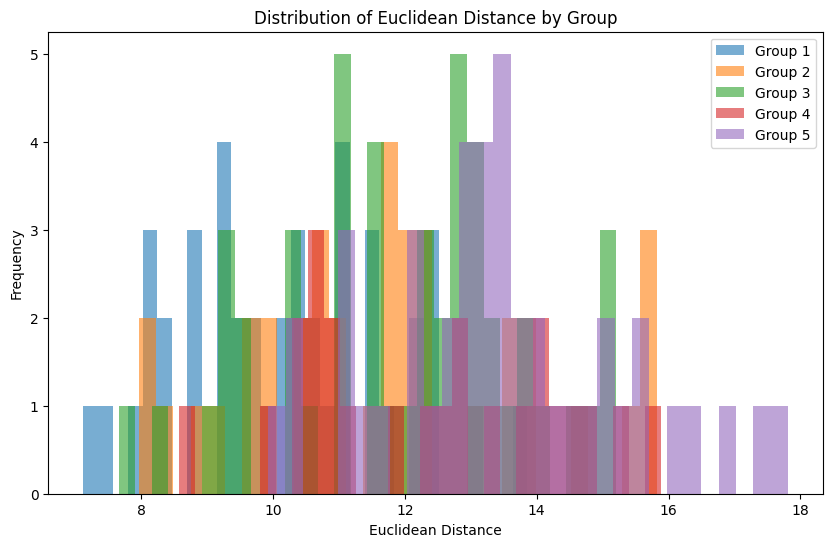

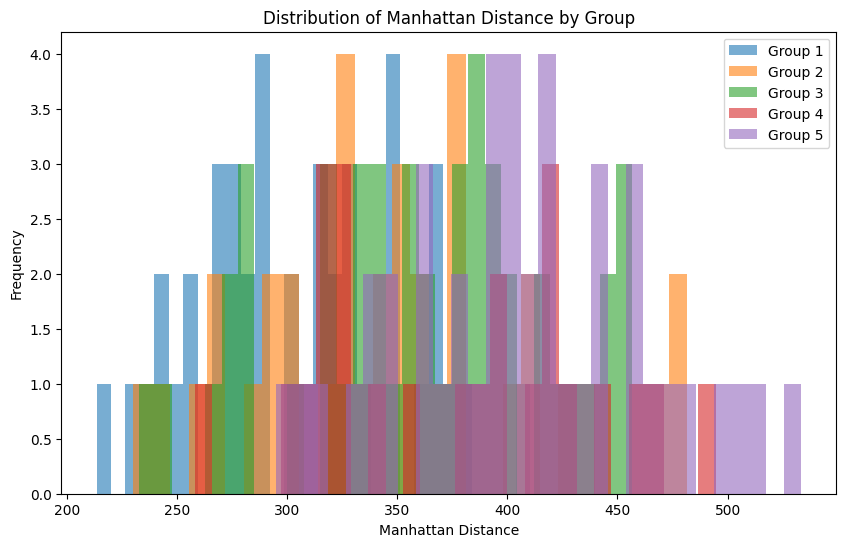

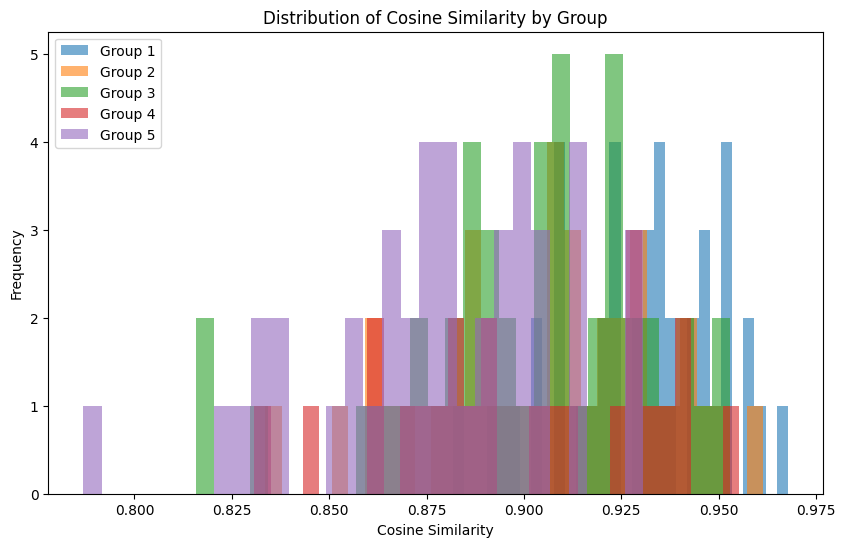

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cityblock  # Manhattan Distance
from sklearn.metrics.pairwise import cosine_similarity

# ResNet50 feature extractor
class ResNet50FeatureExtractor:
    def __init__(self):
        resnet = resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
        self.feature_extractor.eval()

    def extract_features(self, img):
        with torch.no_grad():
            features = self.feature_extractor(img)
            return features.view(features.size(0), -1).squeeze().numpy()  # Flatten

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess images
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

# Compute Metrics
def compute_metrics(feature1, feature2):
    euclid_dist = euclidean(feature1, feature2)
    manhattan_dist = cityblock(feature1, feature2)
    cosine_sim = cosine_similarity(feature1.reshape(1, -1), feature2.reshape(1, -1))[0, 0]
    return euclid_dist, manhattan_dist, cosine_sim

# Process all pairs
def process_all_pairs(csv_file, image_folder, feature_extractor):
    # Load pairs from CSV
    pairs_df = pd.read_csv(csv_file)
    results = {"Target": [], "Euclidean Distance": [], "Manhattan Distance": [], "Cosine Similarity": []}

    for _, row in pairs_df.iterrows():
        img1_path = f"{image_folder}/{row['Image1']}"
        img2_path = f"{image_folder}/{row['Image2']}"
        target = row['Target']

        # Load and preprocess images
        img1 = load_image(img1_path)
        img2 = load_image(img2_path)

        # Extract features
        f1 = feature_extractor.extract_features(img1)
        f2 = feature_extractor.extract_features(img2)

        # Compute metrics
        euclid_dist, manhattan_dist, cosine_sim = compute_metrics(f1, f2)

        # Append results
        results["Target"].append(target)
        results["Euclidean Distance"].append(euclid_dist)
        results["Manhattan Distance"].append(manhattan_dist)
        results["Cosine Similarity"].append(cosine_sim)

    return pd.DataFrame(results)

# Plot distribution
def plot_distributions(results_df):
    metrics = ["Euclidean Distance", "Manhattan Distance", "Cosine Similarity"]
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for target in sorted(results_df["Target"].unique()):
            subset = results_df[results_df["Target"] == target]
            plt.hist(subset[metric], bins=30, alpha=0.6, label=f"Group {target}")
        plt.title(f"Distribution of {metric} by Group")
        plt.xlabel(metric)
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    # Paths
    csv_file = '/content/drive/MyDrive/pairs.csv'  # Path to the CSV file
    image_folder = '/content/drive/MyDrive/refined_data'  # Folder containing images

    # Initialize ResNet50 feature extractor
    feature_extractor = ResNet50FeatureExtractor()

    # Process all pairs
    results_df = process_all_pairs(csv_file, image_folder, feature_extractor)

    # Plot distributions
    plot_distributions(results_df)


#### VGG16

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.2MB/s]


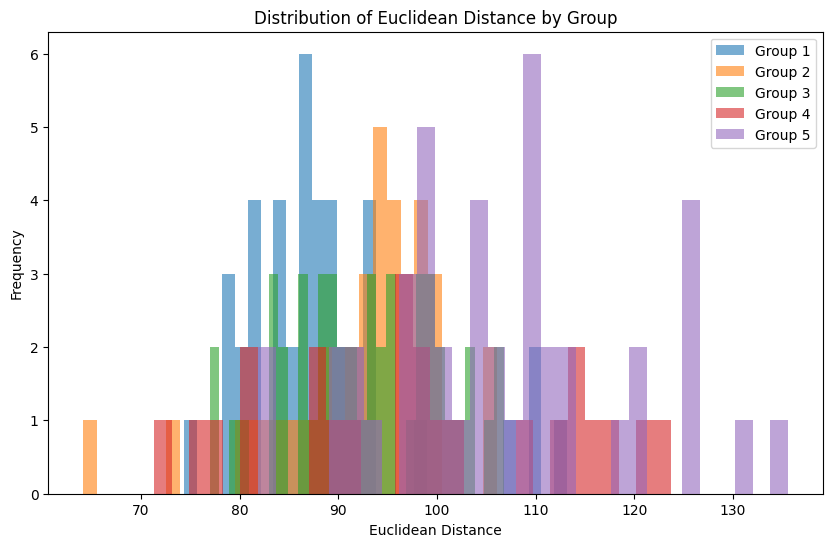

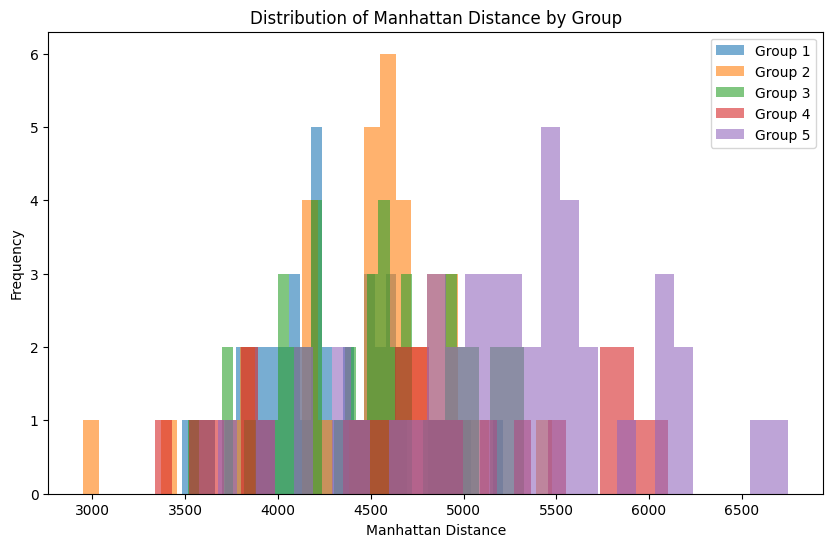

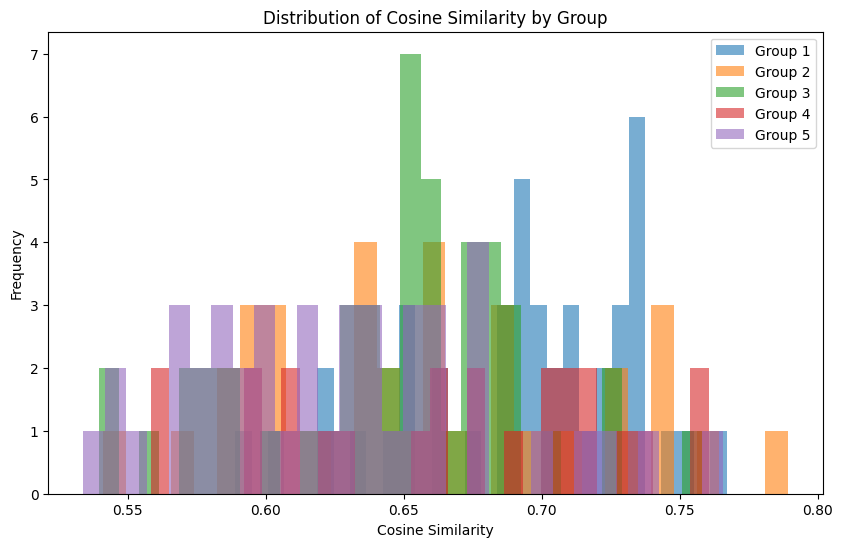

In [ ]:
# File: vgg_similarity.py

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cityblock  # Manhattan (L1) distance
from sklearn.metrics.pairwise import cosine_similarity

# VGG16 feature extractor
class VGG16FeatureExtractor:
    def __init__(self):
        vgg = vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children()))  # Use feature layers
        self.feature_extractor.eval()

    def extract_features(self, img):
        with torch.no_grad():
            features = self.feature_extractor(img)
            return features.view(features.size(0), -1).squeeze().numpy()  # Flatten

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess images
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

# Compute Metrics
def compute_metrics(feature1, feature2):
    euclid_dist = euclidean(feature1, feature2)
    manhattan_dist = cityblock(feature1, feature2)
    cosine_sim = cosine_similarity(feature1.reshape(1, -1), feature2.reshape(1, -1))[0, 0]
    return euclid_dist, manhattan_dist, cosine_sim

# Process all pairs
def process_all_pairs(csv_file, image_folder, feature_extractor):
    # Load pairs from CSV
    pairs_df = pd.read_csv(csv_file)
    results = {"Target": [], "Euclidean Distance": [], "Manhattan Distance": [], "Cosine Similarity": []}

    for _, row in pairs_df.iterrows():
        img1_path = f"{image_folder}/{row['Image1']}"
        img2_path = f"{image_folder}/{row['Image2']}"
        target = row['Target']

        # Load and preprocess images
        img1 = load_image(img1_path)
        img2 = load_image(img2_path)

        # Extract features
        f1 = feature_extractor.extract_features(img1)
        f2 = feature_extractor.extract_features(img2)

        # Compute metrics
        euclid_dist, manhattan_dist, cosine_sim = compute_metrics(f1, f2)

        # Append results
        results["Target"].append(target)
        results["Euclidean Distance"].append(euclid_dist)
        results["Manhattan Distance"].append(manhattan_dist)
        results["Cosine Similarity"].append(cosine_sim)

    return pd.DataFrame(results)

# Plot distribution
def plot_distributions(results_df):
    metrics = ["Euclidean Distance", "Manhattan Distance", "Cosine Similarity"]
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for target in sorted(results_df["Target"].unique()):
            subset = results_df[results_df["Target"] == target]
            plt.hist(subset[metric], bins=30, alpha=0.6, label=f"Group {target}")
        plt.title(f"Distribution of {metric} by Group")
        plt.xlabel(metric)
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    # Paths
    csv_file = '/content/drive/MyDrive/pairs.csv'  # Path to the CSV file
    image_folder = '/content/drive/MyDrive/refined_data'  # Folder containing images

    # Initialize VGG16 feature extractor
    feature_extractor = VGG16FeatureExtractor()

    # Process all pairs
    results_df = process_all_pairs(csv_file, image_folder, feature_extractor)

    # Plot distributions
    plot_distributions(results_df)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


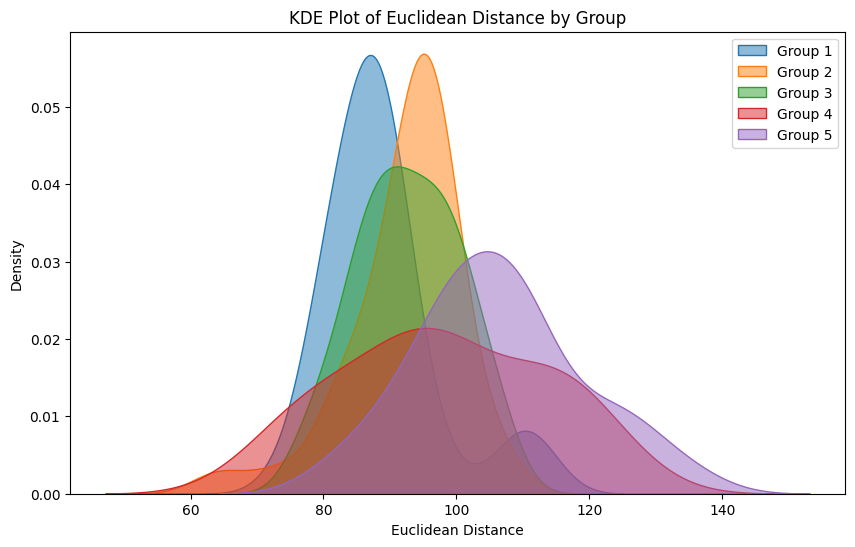

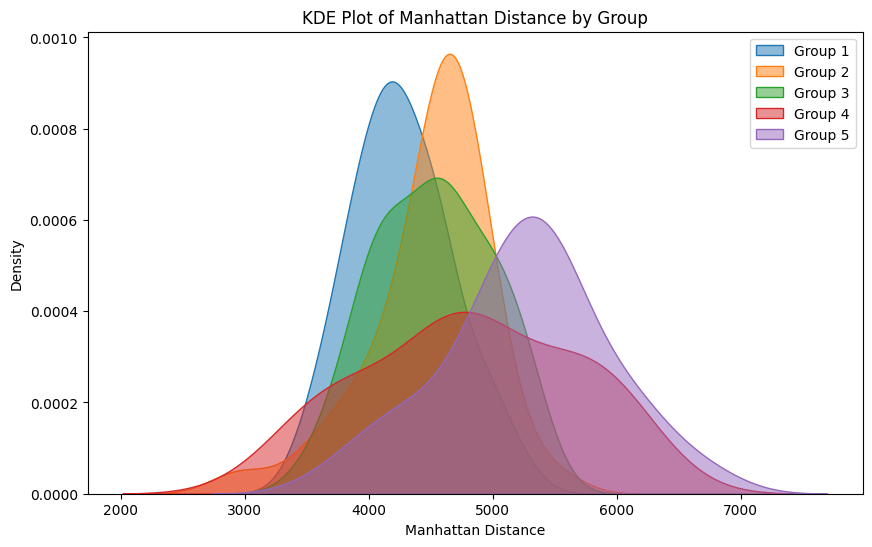

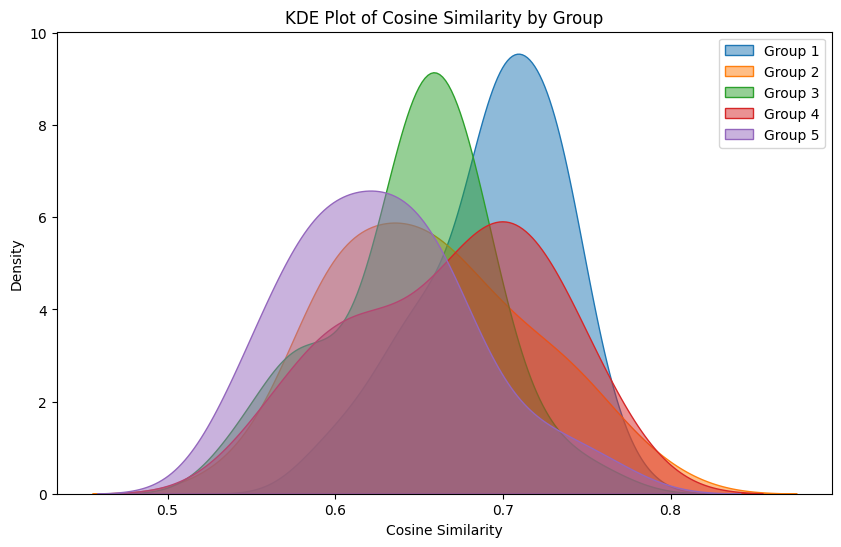

In [ ]:
# File: vgg_similarity.py

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean, cityblock  # Manhattan (L1) distance
from sklearn.metrics.pairwise import cosine_similarity

# VGG16 feature extractor
class VGG16FeatureExtractor:
    def __init__(self):
        vgg = vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children()))  # Use feature layers
        self.feature_extractor.eval()

    def extract_features(self, img):
        with torch.no_grad():
            features = self.feature_extractor(img)
            return features.view(features.size(0), -1).squeeze().numpy()  # Flatten

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess images
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

# Compute Metrics
def compute_metrics(feature1, feature2):
    euclid_dist = euclidean(feature1, feature2)
    manhattan_dist = cityblock(feature1, feature2)
    cosine_sim = cosine_similarity(feature1.reshape(1, -1), feature2.reshape(1, -1))[0, 0]
    return euclid_dist, manhattan_dist, cosine_sim

# Process all pairs
def process_all_pairs(csv_file, image_folder, feature_extractor):
    # Load pairs from CSV
    pairs_df = pd.read_csv(csv_file)
    results = {"Target": [], "Euclidean Distance": [], "Manhattan Distance": [], "Cosine Similarity": []}

    for _, row in pairs_df.iterrows():
        img1_path = f"{image_folder}/{row['Image1']}"
        img2_path = f"{image_folder}/{row['Image2']}"
        target = row['Target']

        # Load and preprocess images
        img1 = load_image(img1_path)
        img2 = load_image(img2_path)

        # Extract features
        f1 = feature_extractor.extract_features(img1)
        f2 = feature_extractor.extract_features(img2)

        # Compute metrics
        euclid_dist, manhattan_dist, cosine_sim = compute_metrics(f1, f2)

        # Append results
        results["Target"].append(target)
        results["Euclidean Distance"].append(euclid_dist)
        results["Manhattan Distance"].append(manhattan_dist)
        results["Cosine Similarity"].append(cosine_sim)

    return pd.DataFrame(results)

# Plot normal (KDE) distribution
def plot_kde_distributions(results_df):
    metrics = ["Euclidean Distance", "Manhattan Distance", "Cosine Similarity"]
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for target in sorted(results_df["Target"].unique()):
            subset = results_df[results_df["Target"] == target]
            sns.kdeplot(subset[metric], label=f"Group {target}", fill=True, alpha=0.5)
        plt.title(f"KDE Plot of {metric} by Group")
        plt.xlabel(metric)
        plt.ylabel("Density")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    # Paths
    csv_file = '/content/drive/MyDrive/pairs.csv'  # Path to the CSV file
    image_folder = '/content/drive/MyDrive/refined_data'  # Folder containing images

    # Initialize VGG16 feature extractor
    feature_extractor = VGG16FeatureExtractor()

    # Process all pairs
    results_df = process_all_pairs(csv_file, image_folder, feature_extractor)

    # Plot KDE distributions
    plot_kde_distributions(results_df)


## Fine-tuning + correlation

### Resnet + MSE


Training with params: Batch size=16, LR=0.001, Epochs=10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Epoch [1/10], Loss: 2.0030
Epoch [2/10], Loss: 1.1898
Epoch [3/10], Loss: 0.9807
Epoch [4/10], Loss: 0.7200
Epoch [5/10], Loss: 0.8078
Epoch [6/10], Loss: 0.7632
Epoch [7/10], Loss: 0.5104
Epoch [8/10], Loss: 0.4115
Epoch [9/10], Loss: 0.3763
Epoch [10/10], Loss: 0.3416
Correlation: 0.6340

Training with params: Batch size=16, LR=0.001, Epochs=20
Epoch [1/20], Loss: 2.6886
Epoch [2/20], Loss: 0.8993
Epoch [3/20], Loss: 0.8773
Epoch [4/20], Loss: 0.6427
Epoch [5/20], Loss: 0.5201
Epoch [6/20], Loss: 0.5212
Epoch [7/20], Loss: 0.5324
Epoch [8/20], Loss: 0.5882
Epoch [9/20], Loss: 0.4188
Epoch [10/20], Loss: 0.3479
Epoch [11/20], Loss: 0.3171
Epoch [12/20], Loss: 0.2796
Epoch [13/20], Loss: 0.2693
Epoch [14/20], Loss: 0.2323
Epoch [15/20], Loss: 0.2695
Epoch [16/20], Loss: 0.2167
Epoch [17/20], Loss: 0.2629
Epoch [18/20], Loss: 0.2097
Epoch [19/20], Loss: 0.1787
Epoch [20/20], Loss: 0.1391
Correlation: 0.8885

Training with params: Batch size=16, LR=0.0001, Epochs=10
Epoch [1/10], Loss: 6

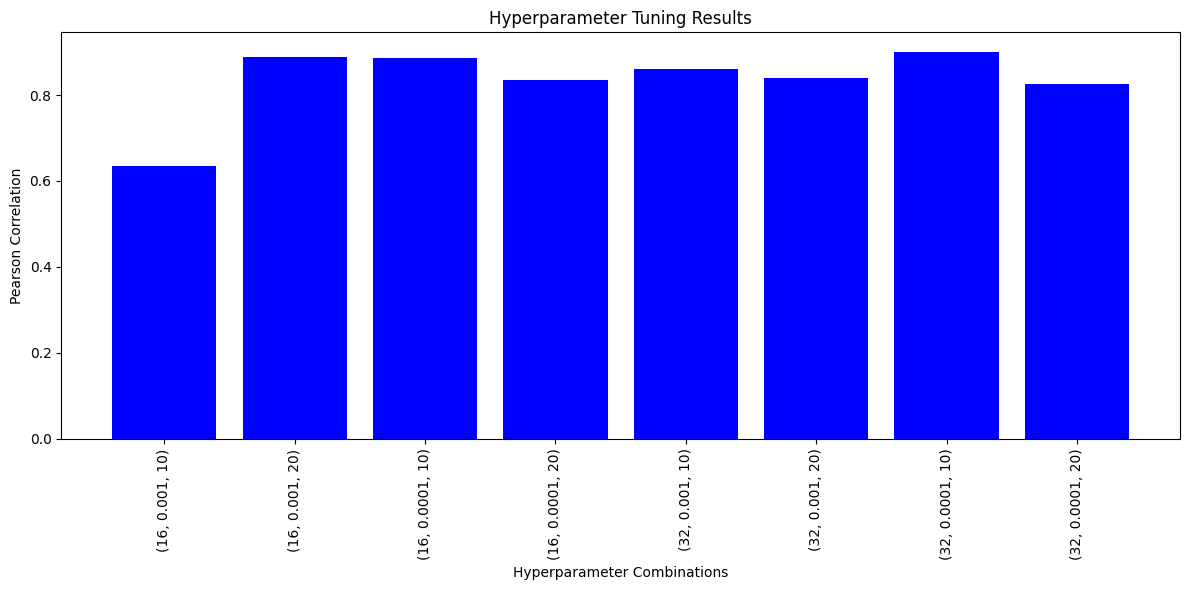


Best Model Parameters: (32, 0.0001, 10)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import product

# Dataset class
class SiameseDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1_path = os.path.join(self.image_folder, self.data.iloc[idx, 0])
        img2_path = os.path.join(self.image_folder, self.data.iloc[idx, 1])
        label = float(self.data.iloc[idx, 2])

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float)

# Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Identity()
        self.embedding_size = 512
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x1, x2):
        f1 = self.base_model(x1)
        f2 = self.base_model(x2)
        diff = torch.abs(f1 - f2)
        similarity = self.fc(diff)
        return similarity

# Training function
def train_siamese_network(model, dataloader, optimizer, criterion, device, num_epochs):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            optimizer.zero_grad()
            predictions = model(img1, img2).view(-1)
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")

# Evaluation function
def evaluate_siamese_network(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            predictions = model(img1, img2).view(-1)
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    # Calculate Pearson correlation
    correlation, _ = pearsonr(predicted_labels, true_labels)
    return correlation

# Hyperparameter tuning
def hyperparameter_tuning(dataset, device, param_grid, transform):
    results = []
    best_model = None
    best_corr = -1
    best_params = None

    # Split dataset
    train_size = int(0.85 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    for params in param_grid:
        batch_size, learning_rate, num_epochs = params
        print(f"\nTraining with params: Batch size={batch_size}, LR={learning_rate}, Epochs={num_epochs}")

        # Prepare data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Model, optimizer, criterion
        model = SiameseNetwork()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        # Train
        train_siamese_network(model, train_loader, optimizer, criterion, device, num_epochs)

        # Evaluate
        correlation = evaluate_siamese_network(model, test_loader, device)
        print(f"Correlation: {correlation:.4f}")

        # Track best model
        if correlation > best_corr:
            best_corr = correlation
            best_model = model
            best_params = params

        # Store results
        results.append((params, correlation))

    return best_model, best_params, results

# Plot results
def plot_results(results):
    params = ["Batch Size", "Learning Rate", "Epochs"]
    x_labels = [f"{p}" for p, _ in results]
    correlations = [corr for _, corr in results]

    plt.figure(figsize=(12, 6))
    plt.bar(x_labels, correlations, color='blue')
    plt.xlabel("Hyperparameter Combinations")
    plt.ylabel("Pearson Correlation")
    plt.title("Hyperparameter Tuning Results")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Paths
    csv_file = '/content/drive/MyDrive/pairs.csv'
    image_folder = '/content/drive/MyDrive/refined_data'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transform
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Dataset
    dataset = SiameseDataset(csv_file, image_folder, transform=transform)

    # Hyperparameter grid
    batch_sizes = [16, 32]
    learning_rates = [0.001, 0.0001]
    num_epochs_list = [10, 20]
    param_grid = list(product(batch_sizes, learning_rates, num_epochs_list))

    # Tuning
    best_model, best_params, results = hyperparameter_tuning(dataset, device, param_grid, transform)

    # Plot results
    plot_results(results)

    print("\nBest Model Parameters:", best_params)
    torch.save(best_model.state_dict(), "best_siamese_model.pth")


### VGG16 + contrastive loss

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Dataset Class
class SiameseDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1_path = os.path.join(self.image_folder, self.data.iloc[idx, 0])
        img2_path = os.path.join(self.image_folder, self.data.iloc[idx, 1])
        label = int(self.data.iloc[idx, 2])  # Multi-class label (1 to 5)

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float)

# Contrastive Loss for Multi-class Labels
class MultiClassContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(MultiClassContrastiveLoss, self).__init__()
        self.margin = margin
        self.label_distances = {1: 0.2, 2: 0.4, 3: 0.6, 4: 0.8, 5: 1.0}  # Mapping labels to distances

    def forward(self, distances, targets):
        positive_loss = torch.pow(distances - torch.tensor([self.label_distances[int(t.item())] for t in targets]).to(distances.device), 2)
        negative_loss = torch.pow(torch.clamp(self.margin - distances, min=0), 2)
        loss = 0.5 * (positive_loss + negative_loss).mean()
        return loss

# Siamese Network using VGG16
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        self.base_model.classifier = nn.Sequential(*list(self.base_model.classifier.children())[:-1])  # Remove final FC
        self.embedding_size = 4096  # VGG16 final feature size
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
        )

    def forward(self, x1, x2):
        f1 = self.fc(self.base_model(x1))
        f2 = self.fc(self.base_model(x2))
        euclidean_distance = torch.sqrt(torch.sum(torch.pow(f1 - f2, 2), dim=1))
        return euclidean_distance.view(-1, 1)

# Training Function
def train_siamese_network(model, dataloader, optimizer, criterion, device, num_epochs=40):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device).view(-1, 1)
            optimizer.zero_grad()
            distances = model(img1, img2)
            loss = criterion(distances, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")
    return model

# Evaluation Function
def evaluate_siamese_network(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_scores = []

    with torch.no_grad():
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            distances = model(img1, img2).view(-1)
            true_labels.extend(target.cpu().numpy())
            predicted_scores.extend(distances.cpu().numpy())

    # Map distances to the closest label based on thresholds
    predicted_classes = [min({1: 0.2, 2: 0.4, 3: 0.6, 4: 0.8, 5: 1.0}.items(), key=lambda x: abs(x[1] - dist))[0] for dist in predicted_scores]

    true_labels = [int(label) for label in true_labels]

    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predicted_classes, labels=[1, 2, 3, 4, 5]))
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_classes, labels=[1, 2, 3, 4, 5]))
    return predicted_scores, true_labels

# Hyperparameter Tuning
def hyperparameter_tuning(csv_file, image_folder, transform, device, param_grid):
    results = []
    dataset = SiameseDataset(csv_file, image_folder, transform=transform)

    train_size = int(0.6 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    for params in param_grid:
        batch_size, learning_rate, margin, num_epochs = params
        print(f"\nTraining with params: Batch size={batch_size}, LR={learning_rate}, Margin={margin}, Epochs={num_epochs}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model = SiameseNetwork()
        criterion = MultiClassContrastiveLoss(margin=margin)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model = train_siamese_network(model, train_loader, optimizer, criterion, device, num_epochs)

        predicted_scores, true_labels = evaluate_siamese_network(model, test_loader, device)

        correlation = torch.corrcoef(torch.stack((torch.tensor(predicted_scores), torch.tensor(true_labels))))[0, 1].item()

        print(f"Pearson Correlation: {correlation:.4f}")
        results.append((params, correlation))

    return results

if __name__ == "__main__":
    csv_file = '/content/drive/MyDrive/pairs.csv'
    image_folder = '/content/drive/MyDrive/refined_data'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    batch_sizes = [16, 32]
    learning_rates = [0.001, 0.0001]
    margins = [1.0, 2.0]
    num_epochs_list = [20, 40]
    param_grid = list(product(batch_sizes, learning_rates, margins, num_epochs_list))

    results = hyperparameter_tuning(csv_file, image_folder, transform, device, param_grid)

    best_params, best_corr = max(results, key=lambda x: x[1])
    print(f"\nBest Parameters: Batch size={best_params[0]}, LR={best_params[1]}, Margin={best_params[2]}, Epochs={best_params[3]}")
    print(f"Best Pearson Correlation: {best_corr:.4f}")



Training with params: Batch size=16, LR=0.001, Margin=1.0, Epochs=20


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 75.4592
Epoch 2/20, Loss: 0.2592
Epoch 3/20, Loss: 0.1301
Epoch 4/20, Loss: 0.1370
Epoch 5/20, Loss: 0.1624
Epoch 6/20, Loss: 0.1075
Epoch 7/20, Loss: 0.0893
Epoch 8/20, Loss: 0.0793
Epoch 9/20, Loss: 0.0679
Epoch 10/20, Loss: 0.0698
Epoch 11/20, Loss: 0.0624
Epoch 12/20, Loss: 0.0626
Epoch 13/20, Loss: 0.0525
Epoch 14/20, Loss: 0.0651
Epoch 15/20, Loss: 0.0539
Epoch 16/20, Loss: 0.0531
Epoch 17/20, Loss: 0.0562
Epoch 18/20, Loss: 0.0560
Epoch 19/20, Loss: 0.0523
Epoch 20/20, Loss: 0.0595
Confusion Matrix:
[[ 0  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [31  0  0  0  0]
 [ 7  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00      18.0
           3       0.00      0.00      0.00      24.0
           4       0.00      0.00      0.00      31.0
           5       0.00      0.00      0.00       7.0

    accuracy                 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/40, Loss: 5.3623
Epoch 2/40, Loss: 0.5737
Epoch 3/40, Loss: 8.5401
Epoch 4/40, Loss: 0.2255
Epoch 5/40, Loss: 0.0827
Epoch 6/40, Loss: 0.0712
Epoch 7/40, Loss: 0.0644
Epoch 8/40, Loss: 0.0539
Epoch 9/40, Loss: 0.0541
Epoch 10/40, Loss: 0.0608
Epoch 11/40, Loss: 0.0592
Epoch 12/40, Loss: 0.0585
Epoch 13/40, Loss: 0.0519
Epoch 14/40, Loss: 0.0597
Epoch 15/40, Loss: 0.0527
Epoch 16/40, Loss: 0.0508
Epoch 17/40, Loss: 0.0549
Epoch 18/40, Loss: 0.0537
Epoch 19/40, Loss: 0.0513
Epoch 20/40, Loss: 0.0511
Epoch 21/40, Loss: 0.0567
Epoch 22/40, Loss: 0.0591
Epoch 23/40, Loss: 0.0601
Epoch 24/40, Loss: 0.0557
Epoch 25/40, Loss: 0.0623
Epoch 26/40, Loss: 0.0544
Epoch 27/40, Loss: 0.0626
Epoch 28/40, Loss: 0.0581
Epoch 29/40, Loss: 0.0653
Epoch 30/40, Loss: 0.0630
Epoch 31/40, Loss: 0.0570
Epoch 32/40, Loss: 0.0524
Epoch 33/40, Loss: 0.0538
Epoch 34/40, Loss: 0.0495
Epoch 35/40, Loss: 0.0539
Epoch 36/40, Loss: 0.0535
Epoch 37/40, Loss: 0.0527
Epoch 38/40, Loss: 0.0520
Epoch 39/40, Loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/20, Loss: 601.0779
Epoch 2/20, Loss: 1.2470
Epoch 3/20, Loss: 0.7897
Epoch 4/20, Loss: 0.5550
Epoch 5/20, Loss: 0.5219
Epoch 6/20, Loss: 0.6775
Epoch 7/20, Loss: 0.5272
Epoch 8/20, Loss: 0.5403
Epoch 9/20, Loss: 0.5012
Epoch 10/20, Loss: 0.5097
Epoch 11/20, Loss: 0.5194
Epoch 12/20, Loss: 0.5208
Epoch 13/20, Loss: 0.5002
Epoch 14/20, Loss: 0.5195
Epoch 15/20, Loss: 0.5256
Epoch 16/20, Loss: 0.4773
Epoch 17/20, Loss: 0.5005
Epoch 18/20, Loss: 0.4687
Epoch 19/20, Loss: 0.4682
Epoch 20/20, Loss: 0.4686
Confusion Matrix:
[[ 0  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [31  0  0  0  0]
 [ 7  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00      18.0
           3       0.00      0.00      0.00      24.0
           4       0.00      0.00      0.00      31.0
           5       0.00      0.00      0.00       7.0

    accuracy                

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/40, Loss: 420.6182
Epoch 2/40, Loss: 0.6149
Epoch 3/40, Loss: 1.6761
Epoch 4/40, Loss: 0.7952
Epoch 5/40, Loss: 0.5394
Epoch 6/40, Loss: 0.5554
Epoch 7/40, Loss: 0.6392
Epoch 8/40, Loss: 0.6898
Epoch 9/40, Loss: 0.5362
Epoch 10/40, Loss: 0.5228
Epoch 11/40, Loss: 0.5104
Epoch 12/40, Loss: 0.5137
Epoch 13/40, Loss: 0.5115
Epoch 14/40, Loss: 0.4986
Epoch 15/40, Loss: 0.4952
Epoch 16/40, Loss: 0.5106
Epoch 17/40, Loss: 0.4926
Epoch 18/40, Loss: 0.4960
Epoch 19/40, Loss: 0.5399
Epoch 20/40, Loss: 0.5327
Epoch 21/40, Loss: 0.4980
Epoch 22/40, Loss: 0.4902
Epoch 23/40, Loss: 0.5028
Epoch 24/40, Loss: 0.4885
Epoch 25/40, Loss: 0.4921
Epoch 26/40, Loss: 0.5092
Epoch 27/40, Loss: 0.5262
Epoch 28/40, Loss: 0.5514
Epoch 29/40, Loss: 0.5644
Epoch 30/40, Loss: 0.5434
Epoch 31/40, Loss: 0.5300
Epoch 32/40, Loss: 0.5055
Epoch 33/40, Loss: 0.4827
Epoch 34/40, Loss: 0.4946
Epoch 35/40, Loss: 0.4797
Epoch 36/40, Loss: 0.4665
Epoch 37/40, Loss: 0.4843
Epoch 38/40, Loss: 0.4759
Epoch 39/40, Loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/20, Loss: 0.6102
Epoch 2/20, Loss: 0.0627
Epoch 3/20, Loss: 0.0549
Epoch 4/20, Loss: 0.0487
Epoch 5/20, Loss: 0.0465
Epoch 6/20, Loss: 0.0469
Epoch 7/20, Loss: 0.0492
Epoch 8/20, Loss: 0.0455
Epoch 9/20, Loss: 0.0488
Epoch 10/20, Loss: 0.0460
Epoch 11/20, Loss: 0.0465
Epoch 12/20, Loss: 0.0474
Epoch 13/20, Loss: 0.0488
Epoch 14/20, Loss: 0.0459
Epoch 15/20, Loss: 0.0471
Epoch 16/20, Loss: 0.0459
Epoch 17/20, Loss: 0.0454
Epoch 18/20, Loss: 0.0478
Epoch 19/20, Loss: 0.0496
Epoch 20/20, Loss: 0.0458
Confusion Matrix:
[[ 0  0  0  0  0]
 [18  0  0  0  0]
 [22  2  0  0  0]
 [30  1  0  0  0]
 [ 7  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00      18.0
           3       0.00      0.00      0.00      24.0
           4       0.00      0.00      0.00      31.0
           5       0.00      0.00      0.00       7.0

    accuracy                  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/40, Loss: 0.7075
Epoch 2/40, Loss: 0.0611
Epoch 3/40, Loss: 0.0600
Epoch 4/40, Loss: 0.0513
Epoch 5/40, Loss: 0.0448
Epoch 6/40, Loss: 0.0477
Epoch 7/40, Loss: 0.0498
Epoch 8/40, Loss: 0.0457
Epoch 9/40, Loss: 0.0456
Epoch 10/40, Loss: 0.0473
Epoch 11/40, Loss: 0.0455
Epoch 12/40, Loss: 0.0463
Epoch 13/40, Loss: 0.0452
Epoch 14/40, Loss: 0.0486
Epoch 15/40, Loss: 0.0491
Epoch 16/40, Loss: 0.0510
Epoch 17/40, Loss: 0.0466
Epoch 18/40, Loss: 0.0470
Epoch 19/40, Loss: 0.0496
Epoch 20/40, Loss: 0.0474
Epoch 21/40, Loss: 0.0438
Epoch 22/40, Loss: 0.0466
Epoch 23/40, Loss: 0.0467
Epoch 24/40, Loss: 0.0508
Epoch 25/40, Loss: 0.0463
Epoch 26/40, Loss: 0.0514
Epoch 27/40, Loss: 0.0453
Epoch 28/40, Loss: 0.0493
Epoch 29/40, Loss: 0.0462
Epoch 30/40, Loss: 0.0471
Epoch 31/40, Loss: 0.0472
Epoch 32/40, Loss: 0.0461
Epoch 33/40, Loss: 0.0451
Epoch 34/40, Loss: 0.0448
Epoch 35/40, Loss: 0.0454
Epoch 36/40, Loss: 0.0487
Epoch 37/40, Loss: 0.0436
Epoch 38/40, Loss: 0.0460
Epoch 39/40, Loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/20, Loss: 1.0836
Epoch 2/20, Loss: 0.4686
Epoch 3/20, Loss: 0.4620
Epoch 4/20, Loss: 0.4668
Epoch 5/20, Loss: 0.4579
Epoch 6/20, Loss: 0.4613
Epoch 7/20, Loss: 0.4710
Epoch 8/20, Loss: 0.4697
Epoch 9/20, Loss: 0.4596
Epoch 10/20, Loss: 0.4616
Epoch 11/20, Loss: 0.4664
Epoch 12/20, Loss: 0.4734
Epoch 13/20, Loss: 0.4651
Epoch 14/20, Loss: 0.4614
Epoch 15/20, Loss: 0.4590
Epoch 16/20, Loss: 0.4611
Epoch 17/20, Loss: 0.4639
Epoch 18/20, Loss: 0.4606
Epoch 19/20, Loss: 0.4643
Epoch 20/20, Loss: 0.4664
Confusion Matrix:
[[ 0  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [31  0  0  0  0]
 [ 7  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00      18.0
           3       0.00      0.00      0.00      24.0
           4       0.00      0.00      0.00      31.0
           5       0.00      0.00      0.00       7.0

    accuracy                  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/40, Loss: 1.1628
Epoch 2/40, Loss: 0.4656
Epoch 3/40, Loss: 0.4636
Epoch 4/40, Loss: 0.4669
Epoch 5/40, Loss: 0.4624
Epoch 6/40, Loss: 0.4598
Epoch 7/40, Loss: 0.4616
Epoch 8/40, Loss: 0.4622
Epoch 9/40, Loss: 0.4614
Epoch 10/40, Loss: 0.4663
Epoch 11/40, Loss: 0.4699
Epoch 12/40, Loss: 0.4661
Epoch 13/40, Loss: 0.4721
Epoch 14/40, Loss: 0.4658
Epoch 15/40, Loss: 0.4606
Epoch 16/40, Loss: 0.4643
Epoch 17/40, Loss: 0.4643
Epoch 18/40, Loss: 0.4594
Epoch 19/40, Loss: 0.4600
Epoch 20/40, Loss: 0.4745
Epoch 21/40, Loss: 0.4642
Epoch 22/40, Loss: 0.4692
Epoch 23/40, Loss: 0.4640
Epoch 24/40, Loss: 0.4617
Epoch 25/40, Loss: 0.4615
Epoch 26/40, Loss: 0.4585
Epoch 27/40, Loss: 0.4648
Epoch 28/40, Loss: 0.4639
Epoch 29/40, Loss: 0.4702
Epoch 30/40, Loss: 0.4607
Epoch 31/40, Loss: 0.4607
Epoch 32/40, Loss: 0.4603
Epoch 33/40, Loss: 0.4605
Epoch 34/40, Loss: 0.4643
Epoch 35/40, Loss: 0.4589
Epoch 36/40, Loss: 0.4628
Epoch 37/40, Loss: 0.4589
Epoch 38/40, Loss: 0.4595
Epoch 39/40, Loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/20, Loss: 446.4612
Epoch 2/20, Loss: 1.2907
Epoch 3/20, Loss: 0.3991
Epoch 4/20, Loss: 0.6719
Epoch 5/20, Loss: 0.0990
Epoch 6/20, Loss: 0.1628
Epoch 7/20, Loss: 0.1049
Epoch 8/20, Loss: 0.0890
Epoch 9/20, Loss: 0.1307
Epoch 10/20, Loss: 0.1150
Epoch 11/20, Loss: 0.0960
Epoch 12/20, Loss: 0.0740
Epoch 13/20, Loss: 0.0983
Epoch 14/20, Loss: 0.1240
Epoch 15/20, Loss: 0.1062
Epoch 16/20, Loss: 0.0799
Epoch 17/20, Loss: 0.0908
Epoch 18/20, Loss: 0.0849
Epoch 19/20, Loss: 0.0797
Epoch 20/20, Loss: 0.0701
Confusion Matrix:
[[ 0  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [31  0  0  0  0]
 [ 7  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00      18.0
           3       0.00      0.00      0.00      24.0
           4       0.00      0.00      0.00      31.0
           5       0.00      0.00      0.00       7.0

    accuracy                

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/40, Loss: 275.2352
Epoch 2/40, Loss: 0.4516
Epoch 3/40, Loss: 0.3291
Epoch 4/40, Loss: 0.3896
Epoch 5/40, Loss: 0.2439
Epoch 6/40, Loss: 0.1056
Epoch 7/40, Loss: 0.1388
Epoch 8/40, Loss: 0.1056
Epoch 9/40, Loss: 0.0941
Epoch 10/40, Loss: 0.0769
Epoch 11/40, Loss: 0.0785
Epoch 12/40, Loss: 0.0634
Epoch 13/40, Loss: 0.0797
Epoch 14/40, Loss: 0.0676
Epoch 15/40, Loss: 0.0655
Epoch 16/40, Loss: 0.0755
Epoch 17/40, Loss: 0.1491
Epoch 18/40, Loss: 0.1105
Epoch 19/40, Loss: 0.0902
Epoch 20/40, Loss: 0.0952
Epoch 21/40, Loss: 0.0757
Epoch 22/40, Loss: 0.0728
Epoch 23/40, Loss: 0.0627
Epoch 24/40, Loss: 0.0683
Epoch 25/40, Loss: 0.0667
Epoch 26/40, Loss: 0.0654
Epoch 27/40, Loss: 0.0671
Epoch 28/40, Loss: 0.0702
Epoch 29/40, Loss: 0.0626
Epoch 30/40, Loss: 0.0692
Epoch 31/40, Loss: 0.0613
Epoch 32/40, Loss: 0.0614
Epoch 33/40, Loss: 0.0612
Epoch 34/40, Loss: 0.0655
Epoch 35/40, Loss: 0.0583
Epoch 36/40, Loss: 0.0657
Epoch 37/40, Loss: 0.0660
Epoch 38/40, Loss: 0.0611
Epoch 39/40, Loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/20, Loss: 768.9346
Epoch 2/20, Loss: 0.8035
Epoch 3/20, Loss: 0.9415
Epoch 4/20, Loss: 0.8349
Epoch 5/20, Loss: 0.5973
Epoch 6/20, Loss: 0.5775
Epoch 7/20, Loss: 1.3046
Epoch 8/20, Loss: 1.7100
Epoch 9/20, Loss: 0.8102
Epoch 10/20, Loss: 0.6981
Epoch 11/20, Loss: 0.6367
Epoch 12/20, Loss: 0.6012
Epoch 13/20, Loss: 0.5726
Epoch 14/20, Loss: 0.5335
Epoch 15/20, Loss: 0.5202
Epoch 16/20, Loss: 0.5133
Epoch 17/20, Loss: 0.5282
Epoch 18/20, Loss: 0.5685
Epoch 19/20, Loss: 0.5660
Epoch 20/20, Loss: 0.5570
Confusion Matrix:
[[ 0  0  0  0  0]
 [18  0  0  0  0]
 [21  3  0  0  0]
 [29  2  0  0  0]
 [ 5  2  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00      18.0
           3       0.00      0.00      0.00      24.0
           4       0.00      0.00      0.00      31.0
           5       0.00      0.00      0.00       7.0

    accuracy                

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/40, Loss: 1075.5859
Epoch 2/40, Loss: 0.9084
Epoch 3/40, Loss: 1.2257
Epoch 4/40, Loss: 3.2267
Epoch 5/40, Loss: 0.8174
Epoch 6/40, Loss: 0.5519
Epoch 7/40, Loss: 0.5626
Epoch 8/40, Loss: 0.5484
Epoch 9/40, Loss: 0.5058
Epoch 10/40, Loss: 0.5088
Epoch 11/40, Loss: 0.5309
Epoch 12/40, Loss: 0.6487
Epoch 13/40, Loss: 0.6201
Epoch 14/40, Loss: 0.5445
Epoch 15/40, Loss: 0.5204
Epoch 16/40, Loss: 0.5541
Epoch 17/40, Loss: 0.5087
Epoch 18/40, Loss: 0.4964
Epoch 19/40, Loss: 0.5707
Epoch 20/40, Loss: 0.5372
Epoch 21/40, Loss: 0.5241
Epoch 22/40, Loss: 0.5158
Epoch 23/40, Loss: 0.5119
Epoch 24/40, Loss: 0.5280
Epoch 25/40, Loss: 0.4870
Epoch 26/40, Loss: 0.4889
Epoch 27/40, Loss: 0.5076
Epoch 28/40, Loss: 0.4912
Epoch 29/40, Loss: 0.5155
Epoch 30/40, Loss: 0.5072
Epoch 31/40, Loss: 0.5167
Epoch 32/40, Loss: 0.5019
Epoch 33/40, Loss: 0.4984
Epoch 34/40, Loss: 0.5027
Epoch 35/40, Loss: 0.4938
Epoch 36/40, Loss: 0.4813
Epoch 37/40, Loss: 0.4880
Epoch 38/40, Loss: 0.5089
Epoch 39/40, Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/20, Loss: 1.3477
Epoch 2/20, Loss: 0.0672
Epoch 3/20, Loss: 0.0722
Epoch 4/20, Loss: 0.0569
Epoch 5/20, Loss: 0.0531
Epoch 6/20, Loss: 0.0551
Epoch 7/20, Loss: 0.0529
Epoch 8/20, Loss: 0.0483
Epoch 9/20, Loss: 0.0472
Epoch 10/20, Loss: 0.0463
Epoch 11/20, Loss: 0.0478
Epoch 12/20, Loss: 0.0458
Epoch 13/20, Loss: 0.0449
Epoch 14/20, Loss: 0.0480
Epoch 15/20, Loss: 0.0455
Epoch 16/20, Loss: 0.0466
Epoch 17/20, Loss: 0.0451
Epoch 18/20, Loss: 0.0446
Epoch 19/20, Loss: 0.0458
Epoch 20/20, Loss: 0.0443
Confusion Matrix:
[[ 0  0  0  0  0]
 [18  0  0  0  0]
 [24  0  0  0  0]
 [31  0  0  0  0]
 [ 7  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00      18.0
           3       0.00      0.00      0.00      24.0
           4       0.00      0.00      0.00      31.0
           5       0.00      0.00      0.00       7.0

    accuracy                  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/40, Loss: 1.2465
Epoch 2/40, Loss: 0.0720
Epoch 3/40, Loss: 0.0684
Epoch 4/40, Loss: 0.0548
Epoch 5/40, Loss: 0.0549
Epoch 6/40, Loss: 0.0478
Epoch 7/40, Loss: 0.0462
Epoch 8/40, Loss: 0.0455
Epoch 9/40, Loss: 0.0493
Epoch 10/40, Loss: 0.0495
Epoch 11/40, Loss: 0.0489
Epoch 12/40, Loss: 0.0466
Epoch 13/40, Loss: 0.0481
Epoch 14/40, Loss: 0.0470
Epoch 15/40, Loss: 0.0463
Epoch 16/40, Loss: 0.0453
Epoch 17/40, Loss: 0.0458
Epoch 18/40, Loss: 0.0448
Epoch 19/40, Loss: 0.0448
Epoch 20/40, Loss: 0.0462
Epoch 21/40, Loss: 0.0468
Epoch 22/40, Loss: 0.0449
Epoch 23/40, Loss: 0.0452
Epoch 24/40, Loss: 0.0470
Epoch 25/40, Loss: 0.0460
Epoch 26/40, Loss: 0.0495
Epoch 27/40, Loss: 0.0514
Epoch 28/40, Loss: 0.0448
Epoch 29/40, Loss: 0.0474
Epoch 30/40, Loss: 0.0493
Epoch 31/40, Loss: 0.0518
Epoch 32/40, Loss: 0.0466
Epoch 33/40, Loss: 0.0458
Epoch 34/40, Loss: 0.0464
Epoch 35/40, Loss: 0.0452
Epoch 36/40, Loss: 0.0462
Epoch 37/40, Loss: 0.0449
Epoch 38/40, Loss: 0.0451
Epoch 39/40, Loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/20, Loss: 1.8731
Epoch 2/20, Loss: 0.5452
Epoch 3/20, Loss: 0.4996
Epoch 4/20, Loss: 0.4744
Epoch 5/20, Loss: 0.4765
Epoch 6/20, Loss: 0.4725
Epoch 7/20, Loss: 0.4727
Epoch 8/20, Loss: 0.4768
Epoch 9/20, Loss: 0.4730
Epoch 10/20, Loss: 0.4617
Epoch 11/20, Loss: 0.4603
Epoch 12/20, Loss: 0.4572
Epoch 13/20, Loss: 0.4576
Epoch 14/20, Loss: 0.4590
Epoch 15/20, Loss: 0.4570
Epoch 16/20, Loss: 0.4568
Epoch 17/20, Loss: 0.4631
Epoch 18/20, Loss: 0.4558
Epoch 19/20, Loss: 0.4633
Epoch 20/20, Loss: 0.4625
Confusion Matrix:
[[ 0  0  0  0  0]
 [17  1  0  0  0]
 [24  0  0  0  0]
 [28  3  0  0  0]
 [ 5  2  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.17      0.06      0.08        18
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        31
           5       0.00      0.00      0.00         7

    accuracy                  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Epoch 1/40, Loss: 1.7714
Epoch 2/40, Loss: 0.5658
Epoch 3/40, Loss: 0.5102
Epoch 4/40, Loss: 0.4919
Epoch 5/40, Loss: 0.4725
Epoch 6/40, Loss: 0.4604
Epoch 7/40, Loss: 0.4643
Epoch 8/40, Loss: 0.4700
Epoch 9/40, Loss: 0.4693
Epoch 10/40, Loss: 0.4665
Epoch 11/40, Loss: 0.4632
Epoch 12/40, Loss: 0.4627
Epoch 13/40, Loss: 0.4650
Epoch 14/40, Loss: 0.4609
Epoch 15/40, Loss: 0.4630
Epoch 16/40, Loss: 0.4584
Epoch 17/40, Loss: 0.4614
Epoch 18/40, Loss: 0.4590
Epoch 19/40, Loss: 0.4578
Epoch 20/40, Loss: 0.4569
Epoch 21/40, Loss: 0.4564
Epoch 22/40, Loss: 0.4621
Epoch 23/40, Loss: 0.4539
Epoch 24/40, Loss: 0.4598
Epoch 25/40, Loss: 0.4619
Epoch 26/40, Loss: 0.4562
Epoch 27/40, Loss: 0.4573
Epoch 28/40, Loss: 0.4625
Epoch 29/40, Loss: 0.4632
Epoch 30/40, Loss: 0.4608
Epoch 31/40, Loss: 0.4658
Epoch 32/40, Loss: 0.4587
Epoch 33/40, Loss: 0.4577
Epoch 34/40, Loss: 0.4572
Epoch 35/40, Loss: 0.4556
Epoch 36/40, Loss: 0.4578
Epoch 37/40, Loss: 0.4612
Epoch 38/40, Loss: 0.4578
Epoch 39/40, Loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

### VGG16 + MSE


Training with params: Batch size=16, LR=0.001, Epochs=10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 108.7745
Epoch [2/10], Loss: 20.1803
Epoch [3/10], Loss: 9.9488
Epoch [4/10], Loss: 2.7800
Epoch [5/10], Loss: 1.4712
Epoch [6/10], Loss: 1.5444
Epoch [7/10], Loss: 0.9993
Epoch [8/10], Loss: 1.0444
Epoch [9/10], Loss: 0.9083
Epoch [10/10], Loss: 1.1380
Correlation: 0.0294

Training with params: Batch size=16, LR=0.001, Epochs=20
Epoch [1/20], Loss: 801.2522
Epoch [2/20], Loss: 5.9511
Epoch [3/20], Loss: 1.6707
Epoch [4/20], Loss: 1.3499
Epoch [5/20], Loss: 1.0961
Epoch [6/20], Loss: 1.3198
Epoch [7/20], Loss: 1.2079
Epoch [8/20], Loss: 0.9755
Epoch [9/20], Loss: 1.1598
Epoch [10/20], Loss: 1.1856
Epoch [11/20], Loss: 1.0587
Epoch [12/20], Loss: 1.2376
Epoch [13/20], Loss: 1.1894
Epoch [14/20], Loss: 1.2505
Epoch [15/20], Loss: 1.1214
Epoch [16/20], Loss: 1.1904
Epoch [17/20], Loss: 1.8347
Epoch [18/20], Loss: 1.4578
Epoch [19/20], Loss: 1.0634
Epoch [20/20], Loss: 0.9462
Correlation: 0.1773

Training with params: Batch size=16, LR=0.0001, Epochs=10
Epoch [1/10], Lo

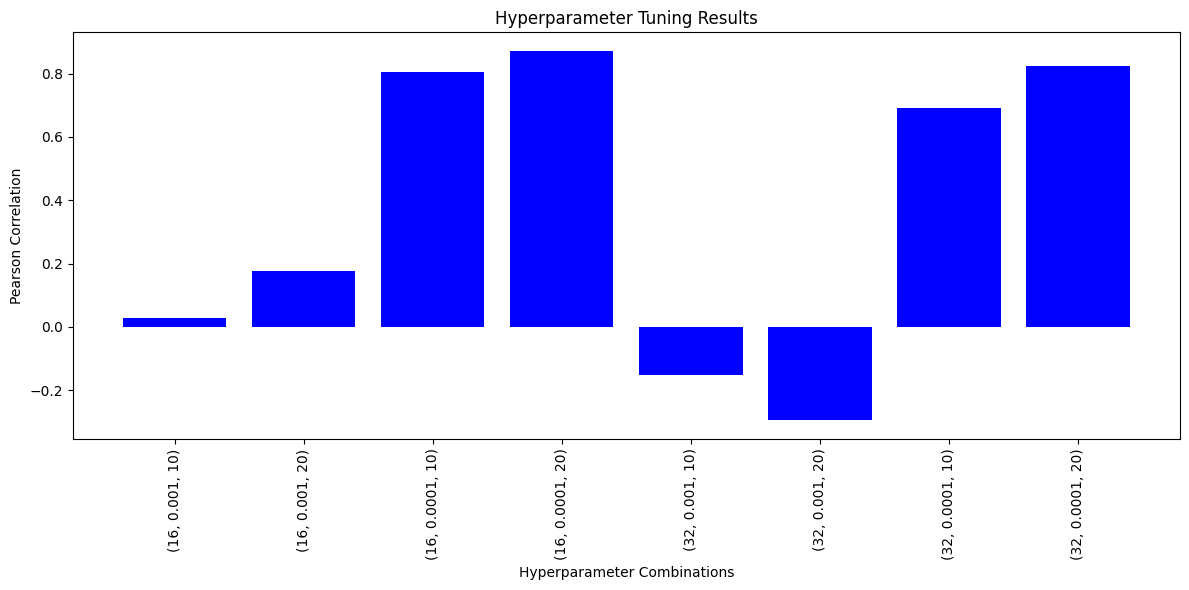


Best Model Parameters: (16, 0.0001, 20)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import product

# Dataset class
class SiameseDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1_path = os.path.join(self.image_folder, self.data.iloc[idx, 0])
        img2_path = os.path.join(self.image_folder, self.data.iloc[idx, 1])
        label = float(self.data.iloc[idx, 2])

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float)

# Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Load the pre-trained VGG16 model
        self.base_model = models.vgg16(pretrained=True)

        # Remove the final fully connected layer to use the output before classification
        self.base_model.classifier = nn.Sequential(*list(self.base_model.classifier.children())[:-1])

        # VGG16's final feature size is 4096
        self.embedding_size = 4096

        # Add a new fully connected layer to map the embedding size to a scalar output
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x1, x2):
        # Get the embeddings of both images from the base model
        f1 = self.base_model(x1)
        f2 = self.base_model(x2)

        # Calculate the absolute difference between the embeddings
        diff = torch.abs(f1 - f2)

        # Feed the difference through the fully connected layers to get the similarity score
        similarity = self.fc(diff)
        return similarity

# Training function
def train_siamese_network(model, dataloader, optimizer, criterion, device, num_epochs):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            optimizer.zero_grad()
            predictions = model(img1, img2).view(-1)
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")

# Evaluation function
def evaluate_siamese_network(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            predictions = model(img1, img2).view(-1)
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    # Calculate Pearson correlation
    correlation, _ = pearsonr(predicted_labels, true_labels)
    return correlation

# Hyperparameter tuning
def hyperparameter_tuning(dataset, device, param_grid, transform):
    results = []
    best_model = None
    best_corr = -1
    best_params = None

    # Split dataset
    train_size = int(0.85 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    for params in param_grid:
        batch_size, learning_rate, num_epochs = params
        print(f"\nTraining with params: Batch size={batch_size}, LR={learning_rate}, Epochs={num_epochs}")

        # Prepare data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Model, optimizer, criterion
        model = SiameseNetwork()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        # Train
        train_siamese_network(model, train_loader, optimizer, criterion, device, num_epochs)

        # Evaluate
        correlation = evaluate_siamese_network(model, test_loader, device)
        print(f"Correlation: {correlation:.4f}")

        # Track best model
        if correlation > best_corr:
            best_corr = correlation
            best_model = model
            best_params = params

        # Store results
        results.append((params, correlation))

    return best_model, best_params, results

# Plot results
def plot_results(results):
    params = ["Batch Size", "Learning Rate", "Epochs"]
    x_labels = [f"{p}" for p, _ in results]
    correlations = [corr for _, corr in results]

    plt.figure(figsize=(12, 6))
    plt.bar(x_labels, correlations, color='blue')
    plt.xlabel("Hyperparameter Combinations")
    plt.ylabel("Pearson Correlation")
    plt.title("Hyperparameter Tuning Results")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Paths
    csv_file = '/content/drive/MyDrive/pairs.csv'
    image_folder = '/content/drive/MyDrive/refined_data'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transform
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Dataset
    dataset = SiameseDataset(csv_file, image_folder, transform=transform)

    # Hyperparameter grid
    batch_sizes = [16, 32]
    learning_rates = [0.001, 0.0001]
    num_epochs_list = [10, 20]
    param_grid = list(product(batch_sizes, learning_rates, num_epochs_list))

    # Tuning
    best_model, best_params, results = hyperparameter_tuning(dataset, device, param_grid, transform)

    # Plot results
    plot_results(results)

    print("\nBest Model Parameters:", best_params)
    torch.save(best_model.state_dict(), "best_siamese_model.pth")


### Resnet + MulSupCon - loss (in problem of loss function)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import product

# Dataset class
class SiameseDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1_path = os.path.join(self.image_folder, self.data.iloc[idx, 0])
        img2_path = os.path.join(self.image_folder, self.data.iloc[idx, 1])
        label = float(self.data.iloc[idx, 2])

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float)

class MultiSupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(MultiSupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        # Normalize the features
        features = nn.functional.normalize(features, p=2, dim=-1)

        # Compute similarity matrix
        similarity_matrix = torch.matmul(features, features.T)

        # Mask to remove self-similarity
        mask = torch.eye(features.size(0), device=features.device).bool()
        similarity_matrix = similarity_matrix[~mask].view(features.size(0), -1)

        # Ensure that labels have the same shape for comparison
        labels = labels.view(-1, 1)
        labels = labels.expand(-1, features.size(0))

        # Positive pairs
        positive_mask = labels == labels.T

        # We need to make sure we properly use the positive_mask for indexing
        positive_similarity = similarity_matrix[positive_mask].view(-1)

        # Negative pairs
        negative_mask = ~positive_mask

        negative_similarity = similarity_matrix[negative_mask].view(-1)

        # Loss calculation
        positive_loss = torch.log(torch.exp(positive_similarity / self.temperature).sum(dim=-1))
        negative_loss = torch.log(torch.exp(negative_similarity / self.temperature).sum(dim=-1))

        # Multi-sample contrastive loss
        loss = torch.mean(positive_loss + negative_loss)
        return loss


# Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_model = models.resnet18(weights='IMAGENET1K_V1')
        self.base_model.fc = nn.Identity()  # Remove the final classification layer
        self.embedding_size = 512  # Output size of resnet18
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x1, x2):
        f1 = self.base_model(x1)
        f2 = self.base_model(x2)
        diff = torch.abs(f1 - f2)
        return diff

# Training function
def train_siamese_network(model, dataloader, optimizer, criterion, device, num_epochs):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            optimizer.zero_grad()
            predictions = model(img1, img2)
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")

# Evaluation function
def evaluate_siamese_network(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for img1, img2, target in dataloader:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)
            predictions = model(img1, img2)
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    # Calculate Pearson correlation
    correlation, _ = pearsonr(predicted_labels, true_labels)
    return correlation

# Hyperparameter tuning
def hyperparameter_tuning(dataset, device, param_grid, transform):
    results = []
    best_model = None
    best_corr = -1
    best_params = None

    # Split dataset
    train_size = int(0.85 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    for params in param_grid:
        batch_size, learning_rate, num_epochs = params
        print(f"\nTraining with params: Batch size={batch_size}, LR={learning_rate}, Epochs={num_epochs}")

        # Prepare data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Model, optimizer, criterion
        model = SiameseNetwork()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = MultiSupConLoss()

        # Train
        train_siamese_network(model, train_loader, optimizer, criterion, device, num_epochs)

        # Evaluate
        correlation = evaluate_siamese_network(model, test_loader, device)
        print(f"Correlation: {correlation:.4f}")

        # Track best model
        if correlation > best_corr:
            best_corr = correlation
            best_model = model
            best_params = params

        # Store results
        results.append((params, correlation))

    return best_model, best_params, results

# Plot results
def plot_results(results):
    params = ["Batch Size", "Learning Rate", "Epochs"]
    x_labels = [f"{p}" for p, _ in results]
    correlations = [corr for _, corr in results]

    plt.figure(figsize=(12, 6))
    plt.bar(x_labels, correlations, color='blue')
    plt.xlabel("Hyperparameter Combinations")
    plt.ylabel("Pearson Correlation")
    plt.title("Hyperparameter Tuning Results")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Paths
    csv_file = '/content/drive/MyDrive/pairs.csv'
    image_folder = '/content/drive/MyDrive/refined_data'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transform
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Dataset
    dataset = SiameseDataset(csv_file, image_folder, transform=transform)

    # Hyperparameter grid
    batch_sizes = [16, 32]
    learning_rates = [0.001, 0.0001]
    num_epochs_list = [10, 20]
    param_grid = list(product(batch_sizes, learning_rates, num_epochs_list))

    # Tuning
    best_model, best_params, results = hyperparameter_tuning(dataset, device, param_grid, transform)

    # Plot results
    plot_results(results)

    print("\nBest Model Parameters:", best_params)
    torch.save(best_model.state_dict(), "best_siamese_model.pth")



Training with params: Batch size=16, LR=0.001, Epochs=10


IndexError: The shape of the mask [16, 16] at index 1 does not match the shape of the indexed tensor [16, 15] at index 1

### Comparison between methods

<ipython-input-13-2d3151d63083>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


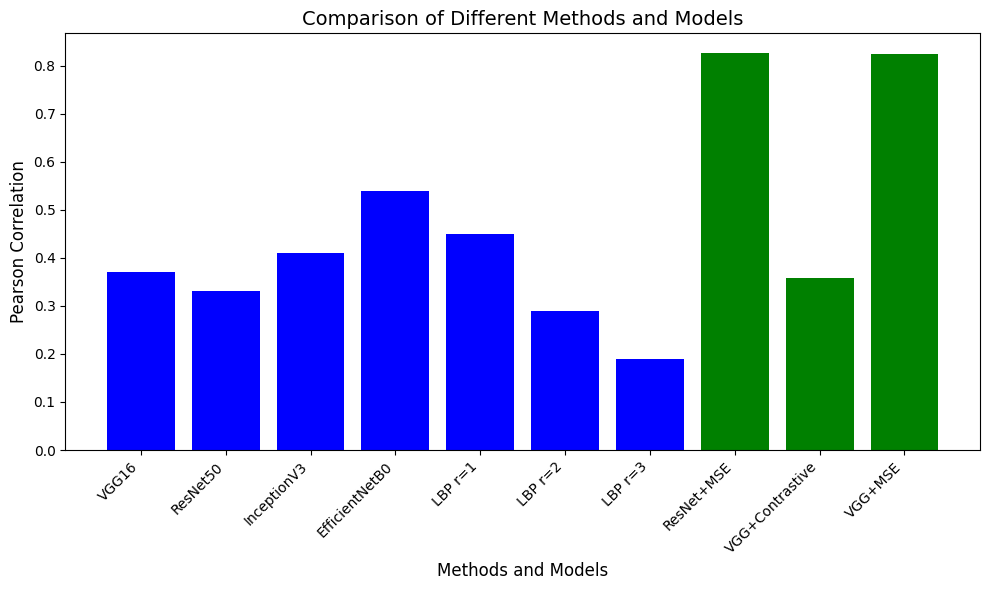

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Method 2
method_2_labels = ['VGG16', 'ResNet50', 'InceptionV3', 'EfficientNetB0', 'LBP r=1', 'LBP r=2', 'LBP r=3']
method_2_values = [0.37, 0.33, 0.41, 0.54, 0.45, 0.29, 0.19]

# Data for Method 3 - SiameseNet
method_3_labels = ['ResNet+MSE', 'VGG+Contrastive', 'VGG+MSE']
method_3_values = [0.8260, 0.3579, 0.8245]

# Combine data
labels = method_2_labels + method_3_labels
values = method_2_values + method_3_values

# Colors: Assigning the same color to all values of Method 2 and Method 3
colors = ['blue'] * len(method_2_values) + ['green'] * len(method_3_values)

# Bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(labels, values, color=colors)

# Adding titles and labels
ax.set_title('Comparison of Different Methods and Models', fontsize=14)
ax.set_xlabel('Methods and Models', fontsize=12)
ax.set_ylabel('Pearson Correlation', fontsize=12)
ax.set_xticklabels(labels, rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()
